# Import packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import sys
import forceatlas2
from fa2 import ForceAtlas2
import igraph
import cairocffi
import scipy

from matplotlib.cm import get_cmap

# Define custom functions

In [2]:
from utils import *

# Import data

## Estimated networks

In [3]:
# Parameters
date = "2020-06-30" #"2020-12-23" or "2020-09-30" or "2020-06-30" or "2020-03-16" or "2019-12-31"
ts_type = "return"
base_path = "./Data/Large_network/Estimated_networks/largenet_"
data_type = "largenet"

# Iterables
methods = ['NS','SPACE','GLASSO','DY','DY_net','DAG']

# Create dictionary to store the outputs
networks = {}

for method in methods:
    
    networks[method] = network_preprocessing_general(date,method,ts_type,base_path)

## Variable names

In [4]:
df = pd.read_csv('./Data/Large_network/largenet_log_ret.csv',sep=",", header=0)

print(df.head())

         Date       JPM       BAC         C       WFC        GS        MS  \
0  2012-01-03  0.000739  0.000788  0.000415  0.000175  0.000497  0.000758   
1  2012-01-04  0.006315  0.001722 -0.005664  0.004562 -0.006523 -0.008744   
2  2012-01-05  0.020672  0.082555  0.011998  0.015978 -0.001690  0.021106   
3  2012-01-06 -0.009010 -0.020817  0.001402 -0.002760 -0.012341 -0.023619   
4  2012-01-09 -0.001698  0.014458  0.018394  0.012363  0.013503  0.018692   

         BK       USB       PNC  ...  BANKBARODA.NS    D05.SI    U11.SI  \
0  0.000406  0.000389  0.000577  ...       0.046850  0.000559  0.000369   
1  0.003407 -0.000363  0.003213  ...       0.001142  0.013582  0.010873   
2  0.008226  0.014762  0.009914  ...      -0.009243 -0.005072 -0.005742   
3 -0.014563 -0.008254  0.001670  ...       0.010953  0.005072 -0.014176   
4  0.020809  0.017504  0.008146  ...      -0.009155 -0.008468 -0.016356   

     EBS.VI  DANSKE.CO   INGA.AS    DNB.OL   SBER.ME  ISCTR.IS    SBK.JO  
0  0.000359

In [5]:
var_names = list(df.columns)[1:]

print(var_names)

['JPM', 'BAC', 'C', 'WFC', 'GS', 'MS', 'BK', 'USB', 'PNC', 'COF', 'STT', 'AXP', 'FITB', 'RF', '8306.T', '8411.T', '8316.T', '8308.T', '8604.T', '8309.T', '8331.T', '8377.T', '8355.T', '8418.T', 'TD.TO', 'RY.TO', 'BNS.TO', 'BMO.TO', 'CM.TO', 'NA.TO', 'UCG.MI', 'ISP.MI', 'UNI.MI', 'MB.MI', 'NAB.AX', 'CBA.AX', 'ANZ.AX', 'WBC.AX', 'MQG.AX', '600036.SS', '600000.SS', '600016.SS', '600015.SS', 'HSBA.L', 'BARC.L', 'LLOY.L', 'STAN.L', 'SAN.MC', 'BBVA.MC', 'SAB.MC', 'SHB-A.ST', 'SEB-A.ST', 'SWED-A.ST', 'BNP.PA', 'ACA.PA', '055550.KS', '024110.KS', 'UBSG.SW', 'CSGN.SW', 'KBC.BR', 'ITUB4.SA', 'BBDC4.SA', 'DBK.DE', 'CBK.DE', 'BIRG.IR', 'SBIN.NS', 'BANKBARODA.NS', 'D05.SI', 'U11.SI', 'EBS.VI', 'DANSKE.CO', 'INGA.AS', 'DNB.OL', 'SBER.ME', 'ISCTR.IS', 'SBK.JO']


## Variable metadata (country etc)

In [6]:
var_metadata = pd.read_excel('./Data/Stock_prices/Bank_tickers.xlsx')

print(var_metadata.head())

             Bank Name Country Bank Code Reuters Ticker Yahoo Finance Ticker
0  JPMorgan Chase & Co      US    jpm.us            jpm                  JPM
1      Bank of America      US    bac.us            bac                  BAC
2            Citigroup      US      c.us              c                    C
3          Wells Fargo      US    wfc.us            wfc                  WFC
4  Goldman Sachs Group      US     gs.us             gs                   GS


In [7]:
countries = []

for var in var_names:
    try:
        country = str(var_metadata[var_metadata['Yahoo Finance Ticker']==var].Country.iloc[0])
        countries.append(country)
        
    except:
        countries.append('Other')

In [8]:
EU_countries = ['Italy','Spain','Sweden','Germany','France','Switzerland','Belgium','Denmark','Ireland',
               'Austria','Netherlands','Norway']

countries = ['EU' if country in EU_countries else country for country in countries]

In [9]:
unique_countries = list(pd.value_counts(countries).index)

In [10]:
unique_countries

['EU',
 'US',
 'Japan',
 'Canada',
 'Australia',
 'UK',
 'China',
 'Singapore',
 'Brazil',
 'Korea',
 'India',
 'Russia',
 'South Africa',
 'Turkey']

In [11]:
# Set colors
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors

name2 = "tab20b"
cmap2 = get_cmap(name2)  # type: matplotlib.colors.ListedColormap
colors2 = cmap2.colors

In [12]:
country_colors = []
collen = len(colors)

for country in countries:
    loc = unique_countries.index(country)
    if loc < collen:
        country_colors.append(colors[loc])
        
    else:
        country_colors.append(colors2[loc-collen])

# Centrality measure comparisons

In [13]:
# Parameters
varnames = var_names
centrality_type = "eigenvector" #"closeness" #"betweenness" #"katz-bonacich"
cross_holdings = False
asset_sizes = False

# Create centrality rankings
if cross_holdings:
    CH_network = CH_network
else:
    CH_network = None
    
if asset_sizes:
    varnames_sorted_by_asset = varnames_sorted_by_asset
else:
    varnames_sorted_by_asset = None
    
# Create centrality rankings
ranking_df = centrality_ranking_df(centrality_type,networks,varnames,varnames_sorted_by_asset,CH_network)

# Inspect the dataframe
display(ranking_df)

NS      SPACE     GLASSO         DY     DY_net        DAG
0          WBC.AX       FITB        BAC     UCG.MI     UCG.MI     DBK.DE
1          ANZ.AX        BAC          C      MB.MI      MB.MI     EBS.VI
2          NAB.AX          C        JPM     EBS.VI     EBS.VI    UBSG.SW
3          CBA.AX     ANZ.AX     BNS.TO     8604.T     8604.T   SHB-A.ST
4            FITB     BNS.TO      TD.TO    INGA.AS    INGA.AS     CBK.DE
..            ...        ...        ...        ...        ...        ...
71         MQG.AX     8355.T  024110.KS  DANSKE.CO  DANSKE.CO  DANSKE.CO
72  BANKBARODA.NS  600000.SS  055550.KS     DNB.OL     DNB.OL     DNB.OL
73        SBER.ME     8604.T  600000.SS    SBER.ME    SBER.ME    SBER.ME
74       ISCTR.IS     8418.T  600015.SS   ISCTR.IS   ISCTR.IS   ISCTR.IS
75         SBK.JO     8377.T  600016.SS     SBK.JO     SBK.JO     SBK.JO

[76 rows x 6 columns]

## Rank correlation (Kendall-Tau)

In [14]:
# Parameters
ts_type = "return"
varnames = var_names
cross_holdings = False
asset_sizes = False
ts_type = "return"
base_path = "./Data/Large_network/Estimated_networks/largenet_"
data_type = "largenet"
chosen_varnames = ["C","WFC","BAC","JPM"]
colors = colors

# Iterables
methods = ['NS','SPACE','GLASSO','DY','DY_net','DAG'] #['NS','SPACE','GLASSO','DAG'] #['NS','SPACE','GLASSO','DY','DAG']
centrality_types = ["eigenvector" ,"closeness" ,"betweenness", "degree" ,"katz-bonacich"]
#dates = ["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"] #["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"]
dates = ["2019-12-31","2020-03-31","2020-06-30","2020-09-30","2020-12-31"] #["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"]


# Run rank correlation comparison function
rank_correlation_comparison(dates,methods,centrality_types,ts_type,base_path,
                            cross_holdings,asset_sizes,colors,varnames)

OSError: ./Data/Large_network/Estimated_networks/largenet_DY_net_return_2020_12_31.csv not found.

# Ranking visualisation

## Method 'winners'

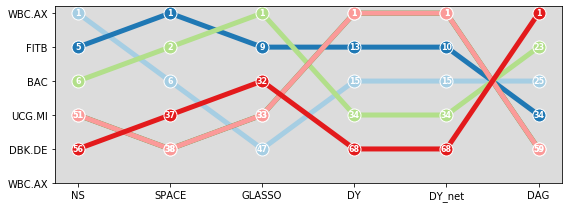

In [15]:
# Parameters
chosen_varnames = list(ranking_df.loc[0])

# Run the visualisation function
rank_viz_general(chosen_varnames,ranking_df,centrality_type,date,ts_type,data_type)

## Custom selection

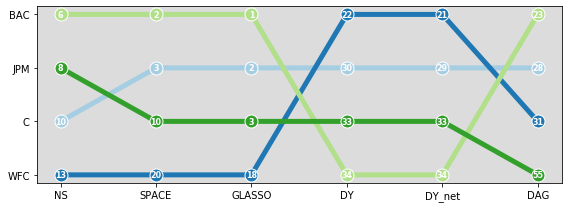

In [16]:
# Parameters
chosen_varnames = ["C","WFC","BAC","JPM"]

# Run the visualisation function
rank_viz_general(chosen_varnames,ranking_df,centrality_type,date,ts_type,data_type)

## Comparisons

Date: 2020-03-16
Centrality type: eigenvector


NS      SPACE     GLASSO         DY     DY_net        DAG
0      8306.T        BAC          C      MB.MI      MB.MI     LLOY.L
1      8316.T          C     BMO.TO         RF         RF    CSGN.SW
2      8308.T        JPM        USB     SAB.MC     SAB.MC     BARC.L
3      8411.T       FITB        BAC      CM.TO      CM.TO     DBK.DE
4      8309.T     BMO.TO        JPM     DNB.OL     ISP.MI     SAN.MC
..        ...        ...        ...        ...        ...        ...
71     STAN.L  600015.SS  600000.SS     BNP.PA     BNP.PA  DANSKE.CO
72  055550.KS  600000.SS  600016.SS     ACA.PA     ACA.PA     DNB.OL
73  024110.KS  600016.SS  600015.SS    UBSG.SW    UBSG.SW    SBER.ME
74     8604.T  024110.KS  024110.KS     D05.SI     D05.SI   ISCTR.IS
75   ISCTR.IS  055550.KS  055550.KS  DANSKE.CO  DANSKE.CO     SBK.JO

[76 rows x 6 columns]

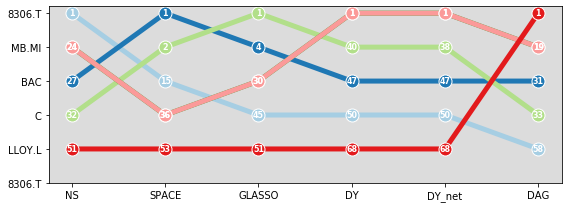

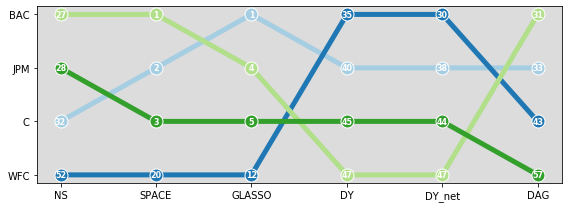

Date: 2020-03-16
Centrality type: closeness


NS      SPACE     GLASSO         DY     DY_net        DAG
0      KBC.BR     BMO.TO     ANZ.AX         BK     SAB.MC     LLOY.L
1      BARC.L     WBC.AX    CSGN.SW   ISCTR.IS     U11.SI     DBK.DE
2    SHB-A.ST     ACA.PA         RF        PNC     CBA.AX     BARC.L
3      ISP.MI         MS     BMO.TO     8309.T     CBK.DE     EBS.VI
4      UNI.MI     ISP.MI     STAN.L     8331.T    BIRG.IR     CBK.DE
..        ...        ...        ...        ...        ...        ...
71    SBIN.NS     DBK.DE  600016.SS     BNP.PA     BNP.PA  DANSKE.CO
72  055550.KS        STT  600015.SS     ACA.PA     ACA.PA     DNB.OL
73  024110.KS      RY.TO    INGA.AS    UBSG.SW    UBSG.SW    SBER.ME
74     8604.T        PNC  600000.SS     D05.SI     D05.SI   ISCTR.IS
75   ISCTR.IS  600016.SS     8308.T  DANSKE.CO  DANSKE.CO     SBK.JO

[76 rows x 6 columns]

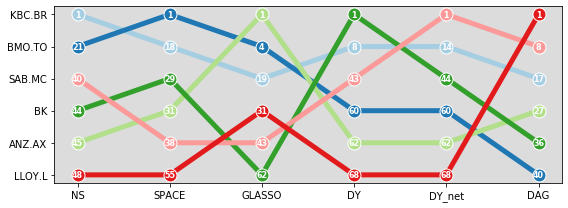

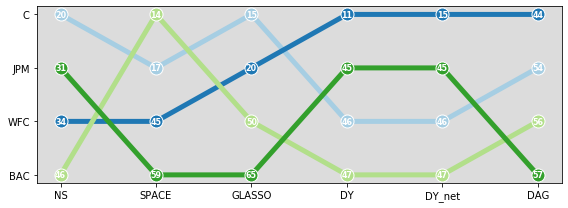

Date: 2020-03-16
Centrality type: betweenness


NS          SPACE     GLASSO         DY     DY_net       DAG
0   SHB-A.ST         BMO.TO  DANSKE.CO   ISCTR.IS   ISCTR.IS    UCG.MI
1     KBC.BR         U11.SI     BMO.TO     U11.SI     8309.T    ISP.MI
2     BARC.L         ACA.PA     UNI.MI         BK    CSGN.SW    BNS.TO
3     MQG.AX         WBC.AX   ISCTR.IS        PNC     U11.SI   BBVA.MC
4          C             MS     BNP.PA     SBK.JO     8331.T    SAN.MC
..       ...            ...        ...        ...        ...       ...
71   SBIN.NS         DBK.DE  600016.SS     D05.SI    SBIN.NS   INGA.AS
72    D05.SI        BIRG.IR    BBVA.MC     EBS.VI     D05.SI    DNB.OL
73    U11.SI        SBIN.NS  024110.KS  DANSKE.CO  DANSKE.CO   SBER.ME
74  ISCTR.IS  BANKBARODA.NS    BIRG.IR    INGA.AS    INGA.AS  ISCTR.IS
75    SBK.JO         EBS.VI    SBIN.NS     DNB.OL     DNB.OL    SBK.JO

[76 rows x 6 columns]

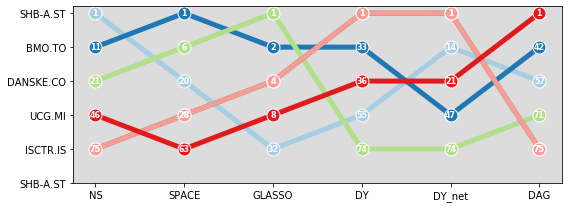

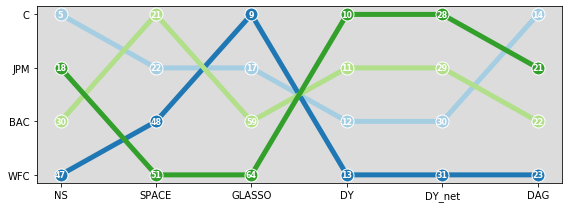

Date: 2020-03-16
Centrality type: degree


NS          SPACE     GLASSO         DY     DY_net        DAG
0          C         BMO.TO     ACA.PA        WFC        WFC        JPM
1     BMO.TO              C     BMO.TO         MS         MS     UCG.MI
2     ISP.MI         ACA.PA        WFC         BK         BK     8306.T
3     ACA.PA        CSGN.SW    CSGN.SW        PNC        PNC     ISP.MI
4    INGA.AS         ISP.MI     EBS.VI        COF        COF     NAB.AX
..       ...            ...        ...        ...        ...        ...
71  ITUB4.SA      024110.KS  600000.SS    UBSG.SW    UBSG.SW  DANSKE.CO
72   SBIN.NS  BANKBARODA.NS  600016.SS     D05.SI     D05.SI     DNB.OL
73    SBK.JO      055550.KS  600015.SS  DANSKE.CO  DANSKE.CO    SBER.ME
74    8604.T       ITUB4.SA  024110.KS  600016.SS  600016.SS   ISCTR.IS
75  ISCTR.IS        SBIN.NS  055550.KS  600015.SS  600015.SS     SBK.JO

[76 rows x 6 columns]

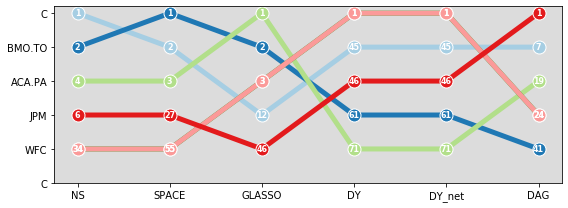

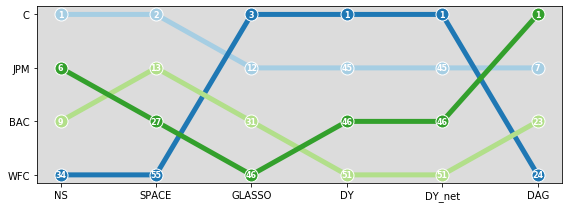

Date: 2020-03-16
Centrality type: katz-bonacich


NS     SPACE     GLASSO         DY     DY_net        DAG
0     ISP.MI    8306.T    INGA.AS      MB.MI      MB.MI    CSGN.SW
1     8306.T    ISP.MI    CSGN.SW      CM.TO      CM.TO     WBC.AX
2        BAC    8316.T     ACA.PA         RF         RF     SAN.MC
3     ANZ.AX         C    UBSG.SW     SAB.MC     SAB.MC      CM.TO
4       FITB      FITB     ISP.MI       FITB       FITB     NAB.AX
..       ...       ...        ...        ...        ...        ...
71    SAB.MC    DNB.OL  024110.KS     BNP.PA     BNP.PA  DANSKE.CO
72    DNB.OL   SBER.ME    SBER.ME     ACA.PA     ACA.PA     DNB.OL
73    SBK.JO    8604.T  055550.KS    UBSG.SW    UBSG.SW    SBER.ME
74    8604.T    SBK.JO     SBK.JO     D05.SI     D05.SI   ISCTR.IS
75  ISCTR.IS  ISCTR.IS   ISCTR.IS  DANSKE.CO  DANSKE.CO     SBK.JO

[76 rows x 6 columns]

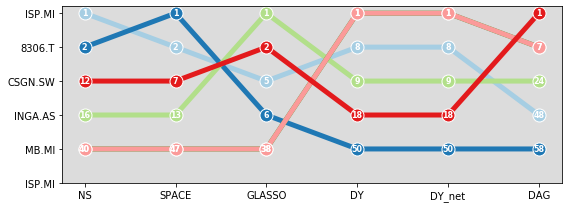

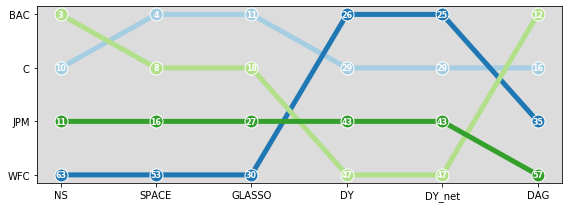

Date: 2020-03-31
Centrality type: eigenvector


NS      SPACE     GLASSO         DY     DY_net        DAG
0          WBC.AX     BMO.TO          C      MB.MI      MB.MI    CSGN.SW
1          ANZ.AX     BNS.TO     BMO.TO     8604.T     8604.T     DBK.DE
2          NAB.AX       FITB        JPM     KBC.BR     KBC.BR     LLOY.L
3          CBA.AX          C        BAC    INGA.AS    INGA.AS      MB.MI
4          MQG.AX        PNC     BNS.TO     EBS.VI     EBS.VI     SAN.MC
..            ...        ...        ...        ...        ...        ...
71         SAB.MC  024110.KS   ISCTR.IS  055550.KS  055550.KS  DANSKE.CO
72        SBIN.NS  055550.KS  600015.SS    UBSG.SW    UBSG.SW     DNB.OL
73  BANKBARODA.NS  600000.SS  055550.KS     D05.SI     D05.SI    SBER.ME
74         UNI.MI  600016.SS  600000.SS     U11.SI     U11.SI   ISCTR.IS
75        SBER.ME  600015.SS  600016.SS   ISCTR.IS   ISCTR.IS     SBK.JO

[76 rows x 6 columns]

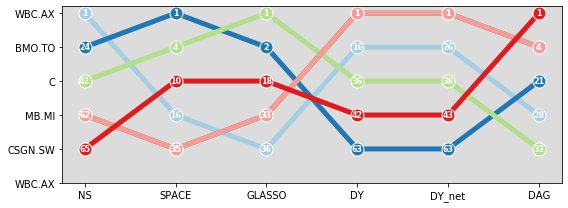

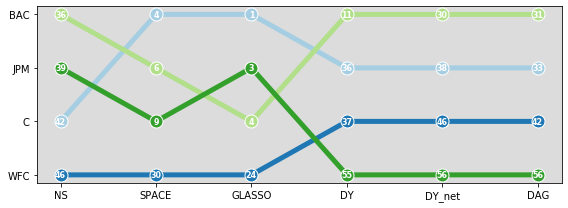

Date: 2020-03-31
Centrality type: closeness


NS      SPACE     GLASSO         DY     DY_net        DAG
0       SWED-A.ST     ANZ.AX    UBSG.SW      TD.TO     STAN.L     LLOY.L
1          ISP.MI  600036.SS     ACA.PA     BNS.TO     8604.T     8418.T
2             WFC    UBSG.SW  SWED-A.ST      RY.TO     8418.T     DBK.DE
3              GS     BARC.L     D05.SI   SEB-A.ST     8309.T     EBS.VI
4           RY.TO   SHB-A.ST         MS     8411.T     8377.T     BARC.L
..            ...        ...        ...        ...        ...        ...
71         CBA.AX        COF       FITB  055550.KS  055550.KS  DANSKE.CO
72       ITUB4.SA     ACA.PA     8377.T    UBSG.SW    UBSG.SW     DNB.OL
73  BANKBARODA.NS       FITB    INGA.AS     D05.SI     D05.SI    SBER.ME
74         WBC.AX         BK  600016.SS     U11.SI     U11.SI   ISCTR.IS
75      600015.SS  600016.SS     8309.T   ISCTR.IS   ISCTR.IS     SBK.JO

[76 rows x 6 columns]

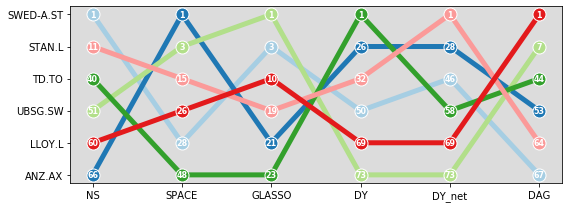

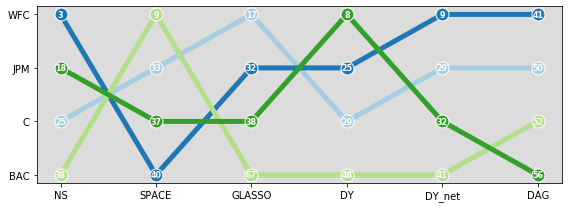

Date: 2020-03-31
Centrality type: betweenness


NS      SPACE     GLASSO        DY    DY_net        DAG
0       SWED-A.ST     ANZ.AX    UBSG.SW  SEB-A.ST    8355.T     UCG.MI
1          ISP.MI    UBSG.SW     ACA.PA     TD.TO  SHB-A.ST     BNP.PA
2             WFC        BAC         MS    8331.T    8377.T     ISP.MI
3          STAN.L     SBK.JO     D05.SI  SHB-A.ST    NAB.AX       FITB
4              GS  600036.SS     ISP.MI    STAN.L    8418.T    BBVA.MC
..            ...        ...        ...       ...       ...        ...
71        CSGN.SW   BBDC4.SA     MQG.AX    EBS.VI   SBIN.NS  DANSKE.CO
72       ITUB4.SA     CBK.DE  600016.SS   INGA.AS    D05.SI     DNB.OL
73  BANKBARODA.NS     EBS.VI     SAN.MC    DNB.OL    U11.SI    SBER.ME
74         EBS.VI  DANSKE.CO  024110.KS  ISCTR.IS   INGA.AS   ISCTR.IS
75       ISCTR.IS     DNB.OL    INGA.AS    SBK.JO  ISCTR.IS     SBK.JO

[76 rows x 6 columns]

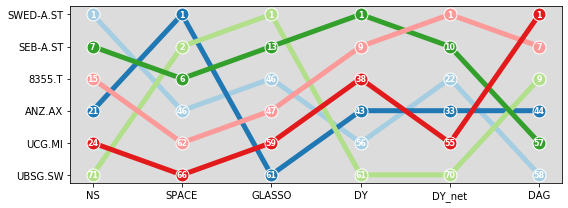

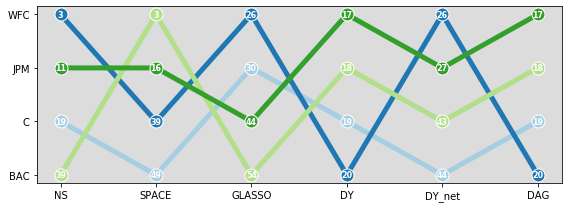

Date: 2020-03-31
Centrality type: degree


NS      SPACE     GLASSO         DY     DY_net        DAG
0          ISP.MI    BBVA.MC     ACA.PA        JPM        JPM        JPM
1         INGA.AS        BAC    UBSG.SW        BAC        BAC     UCG.MI
2             JPM     BMO.TO   SEB-A.ST          C          C      TD.TO
3             BAC     ISP.MI      NA.TO        WFC        WFC     ISP.MI
4              GS    UBSG.SW     BARC.L         GS         GS     8306.T
..            ...        ...        ...        ...        ...        ...
71         CBA.AX         RF    SBIN.NS    UBSG.SW    UBSG.SW  DANSKE.CO
72         HSBA.L  600016.SS     8377.T     D05.SI     D05.SI     DNB.OL
73       ITUB4.SA  024110.KS  055550.KS     U11.SI     U11.SI    SBER.ME
74  BANKBARODA.NS     EBS.VI  024110.KS   ISCTR.IS   ISCTR.IS   ISCTR.IS
75       ISCTR.IS   ITUB4.SA  600016.SS  600016.SS  600016.SS     SBK.JO

[76 rows x 6 columns]

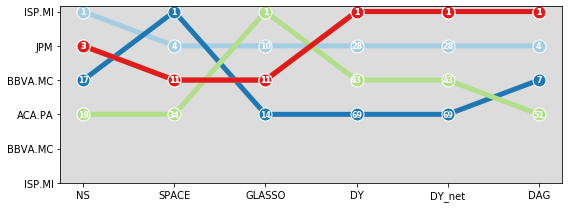

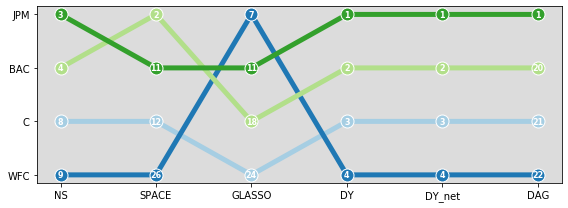

Date: 2020-03-31
Centrality type: katz-bonacich


NS     SPACE     GLASSO         DY     DY_net        DAG
0     8306.T    ISP.MI    CSGN.SW      MB.MI      MB.MI    CSGN.SW
1     ISP.MI    BMO.TO     BMO.TO     KBC.BR      CM.TO     BNS.TO
2     ANZ.AX    8306.T     ISP.MI      CM.TO     KBC.BR     BMO.TO
3       FITB   CSGN.SW    UBSG.SW    INGA.AS     8604.T   ITUB4.SA
4    BBVA.MC   BBVA.MC    BBVA.MC     8604.T    INGA.AS      CM.TO
..       ...       ...        ...        ...        ...        ...
71    DNB.OL    UNI.MI     8604.T  055550.KS  055550.KS  DANSKE.CO
72   SBER.ME    DNB.OL  055550.KS    UBSG.SW    UBSG.SW     DNB.OL
73    8604.T    8604.T     HSBA.L     D05.SI     D05.SI    SBER.ME
74  SEB-A.ST   SBER.ME    SBER.ME     U11.SI     U11.SI   ISCTR.IS
75  ISCTR.IS  ISCTR.IS   ISCTR.IS   ISCTR.IS   ISCTR.IS     SBK.JO

[76 rows x 6 columns]

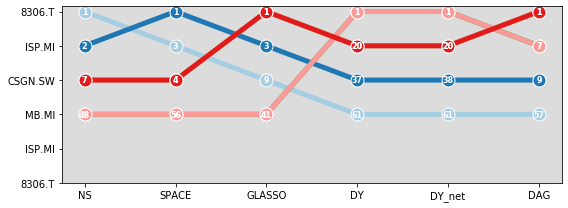

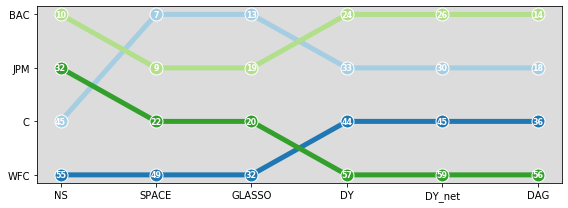

Date: 2020-06-30
Centrality type: eigenvector


NS      SPACE     GLASSO         DY     DY_net        DAG
0          WBC.AX       FITB        BAC     UCG.MI     UCG.MI     DBK.DE
1          ANZ.AX        BAC          C      MB.MI      MB.MI     EBS.VI
2          NAB.AX          C        JPM     EBS.VI     EBS.VI    UBSG.SW
3          CBA.AX     ANZ.AX     BNS.TO     8604.T     8604.T   SHB-A.ST
4            FITB     BNS.TO      TD.TO    INGA.AS    INGA.AS     CBK.DE
..            ...        ...        ...        ...        ...        ...
71         MQG.AX     8355.T  024110.KS  DANSKE.CO  DANSKE.CO  DANSKE.CO
72  BANKBARODA.NS  600000.SS  055550.KS     DNB.OL     DNB.OL     DNB.OL
73        SBER.ME     8604.T  600000.SS    SBER.ME    SBER.ME    SBER.ME
74       ISCTR.IS     8418.T  600015.SS   ISCTR.IS   ISCTR.IS   ISCTR.IS
75         SBK.JO     8377.T  600016.SS     SBK.JO     SBK.JO     SBK.JO

[76 rows x 6 columns]

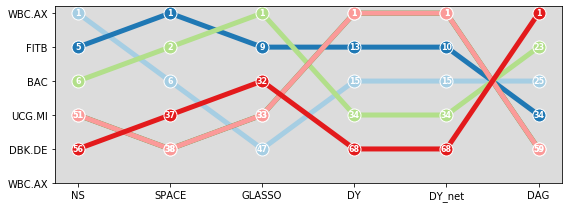

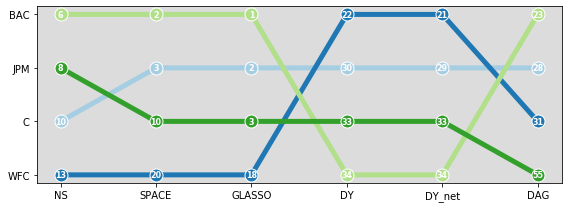

Date: 2020-06-30
Centrality type: closeness


NS      SPACE     GLASSO         DY     DY_net        DAG
0      CBK.DE  600000.SS     SAB.MC      RY.TO      RY.TO     DBK.DE
1     BIRG.IR     BMO.TO     BMO.TO     KBC.BR     KBC.BR   SHB-A.ST
2      ACA.PA     BARC.L     DBK.DE     UNI.MI     8604.T     CBK.DE
3     INGA.AS     UCG.MI        AXP          C     UCG.MI    UBSG.SW
4      DBK.DE        BAC      MB.MI     NAB.AX     ISP.MI     EBS.VI
..        ...        ...        ...        ...        ...        ...
71     NAB.AX     8309.T     8309.T  DANSKE.CO  DANSKE.CO  DANSKE.CO
72     ANZ.AX     8316.T     8331.T     DNB.OL     DNB.OL     DNB.OL
73     CBA.AX     UNI.MI  055550.KS    SBER.ME    SBER.ME    SBER.ME
74     WBC.AX     CBA.AX     8377.T   ISCTR.IS   ISCTR.IS   ISCTR.IS
75  055550.KS  600016.SS     8418.T     SBK.JO     SBK.JO     SBK.JO

[76 rows x 6 columns]

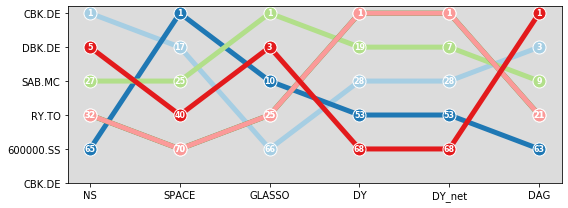

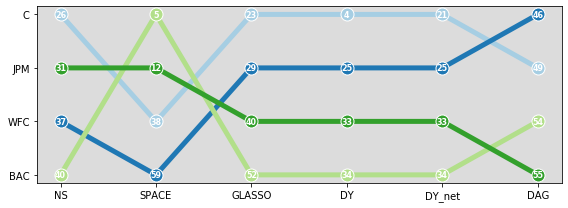

Date: 2020-06-30
Centrality type: betweenness


NS          SPACE     GLASSO         DY     DY_net        DAG
0          CBK.DE      600000.SS     SAB.MC  SWED-A.ST     UNI.MI    BBVA.MC
1         INGA.AS         BMO.TO     BMO.TO          C  SWED-A.ST     BARC.L
2          ACA.PA            AXP     LLOY.L     KBC.BR          C     SAN.MC
3             AXP            BAC     BNP.PA     NAB.AX    BBVA.MC     ACA.PA
4       DANSKE.CO         BARC.L        AXP     ISP.MI      RY.TO    CSGN.SW
..            ...            ...        ...        ...        ...        ...
71  BANKBARODA.NS        SBIN.NS     CBK.DE  DANSKE.CO  DANSKE.CO  DANSKE.CO
72         D05.SI  BANKBARODA.NS    SBIN.NS     DNB.OL     DNB.OL     DNB.OL
73         EBS.VI         U11.SI     D05.SI    SBER.ME    SBER.ME    SBER.ME
74       ISCTR.IS         EBS.VI  DANSKE.CO   ISCTR.IS   ISCTR.IS   ISCTR.IS
75         SBK.JO      DANSKE.CO    INGA.AS     SBK.JO     SBK.JO     SBK.JO

[76 rows x 6 columns]

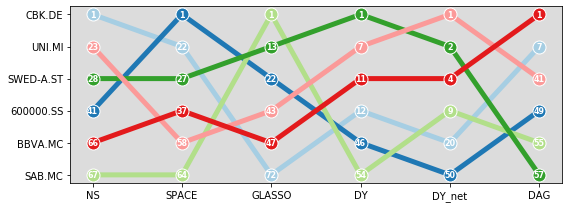

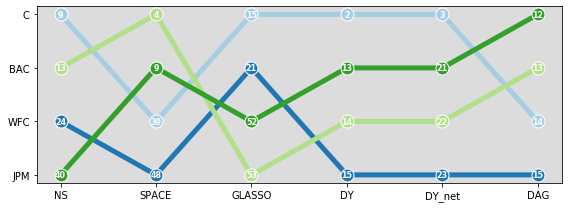

Date: 2020-06-30
Centrality type: degree


NS          SPACE     GLASSO         DY     DY_net        DAG
0          ACA.PA            BAC     BNP.PA          C          C        JPM
1         INGA.AS         BMO.TO     ACA.PA        COF        COF      TD.TO
2             BAC       SEB-A.ST     BARC.L        AXP        AXP     8306.T
3               C         ACA.PA    CSGN.SW       FITB       FITB     NAB.AX
4             AXP        CSGN.SW      NA.TO         RF         RF     SAN.MC
..            ...            ...        ...        ...        ...        ...
71       ITUB4.SA      055550.KS     8418.T  600016.SS  600016.SS  DANSKE.CO
72  BANKBARODA.NS      024110.KS  600015.SS  600015.SS  600015.SS     DNB.OL
73         D05.SI       BBDC4.SA  024110.KS     HSBA.L     HSBA.L    SBER.ME
74       ISCTR.IS  BANKBARODA.NS  055550.KS    SBER.ME    SBER.ME   ISCTR.IS
75         SBK.JO       ITUB4.SA  600016.SS   ISCTR.IS   ISCTR.IS     SBK.JO

[76 rows x 6 columns]

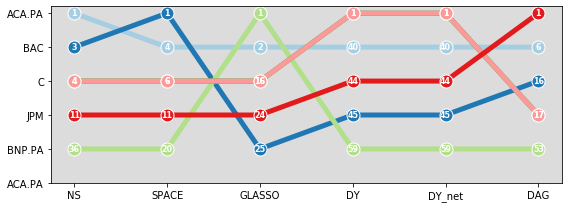

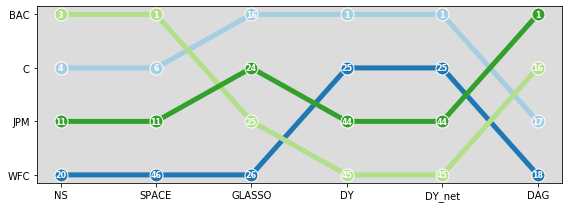

Date: 2020-06-30
Centrality type: katz-bonacich


NS     SPACE         GLASSO         DY     DY_net        DAG
0    CSGN.SW   CSGN.SW        CSGN.SW      MB.MI      MB.MI     BNS.TO
1     ACA.PA    8306.T         ACA.PA      CM.TO      CM.TO      RY.TO
2       FITB    ANZ.AX        BBVA.MC     UCG.MI     UCG.MI      CM.TO
3        BAC    ACA.PA         BMO.TO       FITB       FITB     SAN.MC
4     8306.T    BNS.TO         CBK.DE        COF        COF     BMO.TO
..       ...       ...            ...        ...        ...        ...
71   SBER.ME    8604.T         UNI.MI  DANSKE.CO  DANSKE.CO  DANSKE.CO
72    MQG.AX    CBA.AX       ITUB4.SA     DNB.OL     DNB.OL     DNB.OL
73  ISCTR.IS    SBK.JO  BANKBARODA.NS    SBER.ME    SBER.ME    SBER.ME
74    SBK.JO  ISCTR.IS       ISCTR.IS   ISCTR.IS   ISCTR.IS   ISCTR.IS
75    8604.T   SBER.ME        SBER.ME     SBK.JO     SBK.JO     SBK.JO

[76 rows x 6 columns]

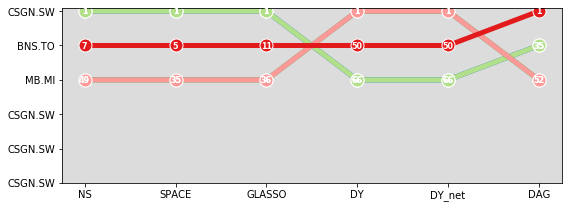

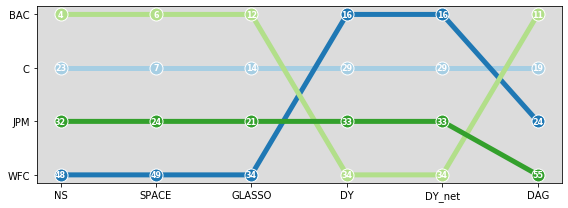

Date: 2020-09-30
Centrality type: eigenvector


NS          SPACE     GLASSO         DY     DY_net       DAG
0     WBC.AX         WBC.AX        BAC     UCG.MI     UCG.MI       PNC
1     ANZ.AX         ANZ.AX        JPM      MB.MI      MB.MI      FITB
2     NAB.AX           FITB          C     ISP.MI     ISP.MI  BBDC4.SA
3     CBA.AX            BAC      TD.TO    INGA.AS    INGA.AS       STT
4       FITB         NAB.AX     BNS.TO     EBS.VI     EBS.VI    CBK.DE
..       ...            ...        ...        ...        ...       ...
71    D05.SI         8418.T  055550.KS  DANSKE.CO  DANSKE.CO    BNS.TO
72    8604.T        SBER.ME  600036.SS     DNB.OL     DNB.OL     RY.TO
73    MQG.AX         8604.T  600000.SS    SBER.ME    SBER.ME       COF
74  ISCTR.IS         8377.T  600016.SS   ISCTR.IS   ISCTR.IS     TD.TO
75    SBK.JO  BANKBARODA.NS  600015.SS     SBK.JO     SBK.JO       JPM

[76 rows x 6 columns]

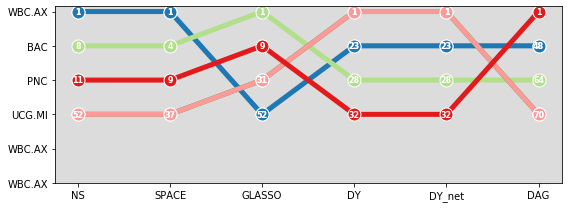

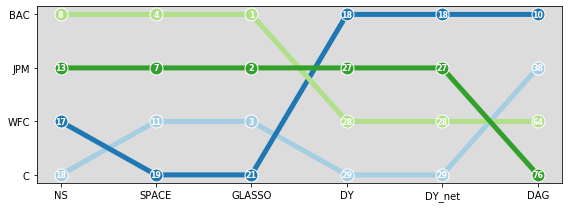

Date: 2020-09-30
Centrality type: closeness


NS      SPACE     GLASSO         DY     DY_net     DAG
0      8331.T     8604.T     CBK.DE  SWED-A.ST  SWED-A.ST  EBS.VI
1      8308.T        AXP     DNB.OL    INGA.AS    INGA.AS  8316.T
2     CSGN.SW   SEB-A.ST   SEB-A.ST     MQG.AX     ISP.MI     PNC
3      LLOY.L     ISP.MI     STAN.L        COF     8604.T      BK
4      ACA.PA      TD.TO    BBVA.MC     ANZ.AX      CM.TO   NA.TO
..        ...        ...        ...        ...        ...     ...
71  024110.KS         BK      TD.TO  DANSKE.CO  DANSKE.CO   RY.TO
72     8604.T     8316.T      MB.MI     DNB.OL     DNB.OL  BNS.TO
73     MQG.AX        USB     8418.T    SBER.ME    SBER.ME   TD.TO
74   ISCTR.IS  600016.SS  600015.SS   ISCTR.IS   ISCTR.IS     COF
75     SBK.JO   ITUB4.SA  600016.SS     SBK.JO     SBK.JO     JPM

[76 rows x 6 columns]

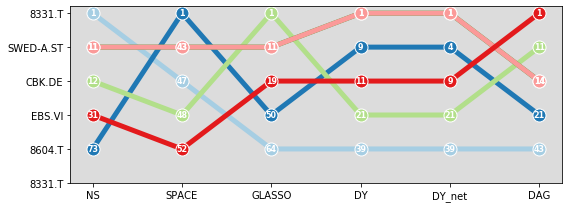

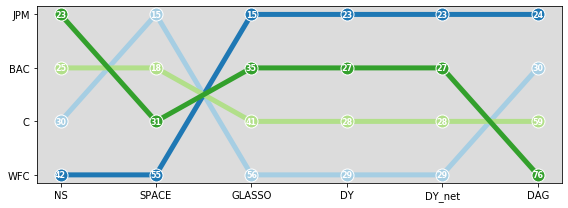

Date: 2020-09-30
Centrality type: betweenness


NS          SPACE     GLASSO        DY    DY_net        DAG
0         GS         8604.T     DNB.OL     CM.TO     CM.TO     MQG.AX
1    CSGN.SW          TD.TO     CBK.DE    ANZ.AX    ANZ.AX     8308.T
2        AXP            AXP    BBVA.MC      FITB      FITB    INGA.AS
3      RY.TO       SEB-A.ST   SEB-A.ST    8604.T    8604.T  600000.SS
4        JPM         ISP.MI  SWED-A.ST    MQG.AX    SAB.MC     KBC.BR
..       ...            ...        ...       ...       ...        ...
71    EBS.VI        CSGN.SW     SAB.MC   INGA.AS   INGA.AS     8604.T
72    DNB.OL         KBC.BR  055550.KS    DNB.OL    DNB.OL      NA.TO
73   SBER.ME       ITUB4.SA    SBIN.NS   SBER.ME   SBER.ME      MB.MI
74  ISCTR.IS  BANKBARODA.NS  DANSKE.CO  ISCTR.IS  ISCTR.IS     STAN.L
75    SBK.JO        SBER.ME    SBER.ME    SBK.JO    SBK.JO     EBS.VI

[76 rows x 6 columns]

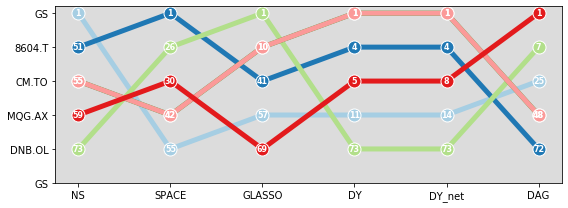

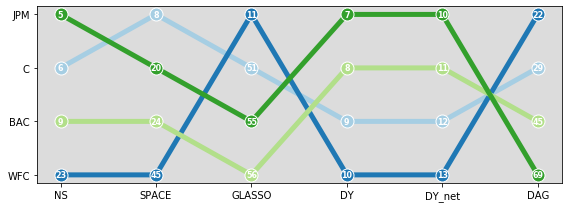

Date: 2020-09-30
Centrality type: degree


NS          SPACE     GLASSO         DY     DY_net            DAG
0     ACA.PA       SEB-A.ST     BNP.PA        COF     UCG.MI            JPM
1        BAC         BARC.L     ACA.PA       FITB        COF         UCG.MI
2    CSGN.SW        INGA.AS    CSGN.SW     8604.T       FITB         UNI.MI
3         MS          TD.TO     BARC.L      CM.TO     8604.T         8306.T
4          C            AXP      CM.TO      MB.MI      CM.TO         8377.T
..       ...            ...        ...        ...        ...            ...
71   SBER.ME      600015.SS    SBER.ME     DBK.DE     DBK.DE        UBSG.SW
72    8604.T      055550.KS     8418.T  DANSKE.CO  DANSKE.CO  BANKBARODA.NS
73    MQG.AX       BBDC4.SA  055550.KS     DNB.OL     DNB.OL            BAC
74  ISCTR.IS  BANKBARODA.NS  600016.SS    SBER.ME    SBER.ME         8418.T
75    SBK.JO       ITUB4.SA  600015.SS   ISCTR.IS   ISCTR.IS         SAB.MC

[76 rows x 6 columns]

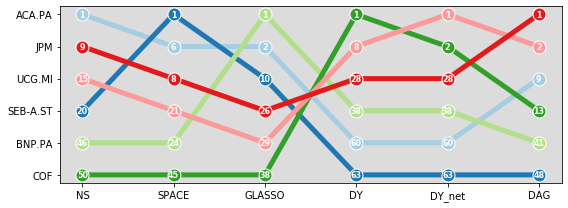

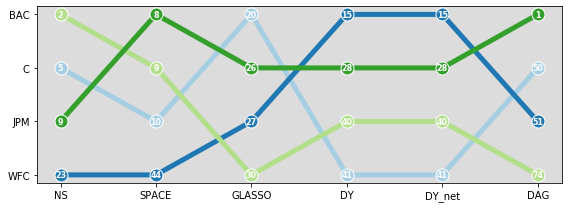

Date: 2020-09-30
Centrality type: katz-bonacich


NS     SPACE         GLASSO         DY     DY_net       DAG
0      ACA.PA    8306.T         ACA.PA      MB.MI      MB.MI    EBS.VI
1        FITB   CSGN.SW        CSGN.SW     ISP.MI     ISP.MI    8411.T
2         BAC    ANZ.AX         BMO.TO       FITB       FITB   SBIN.NS
3     CSGN.SW    ACA.PA         BNP.PA     UCG.MI     UCG.MI    8604.T
4   600016.SS    SAN.MC         BARC.L      CM.TO      CM.TO    BNP.PA
..        ...       ...            ...        ...        ...       ...
71    SBER.ME    MQG.AX       ITUB4.SA  DANSKE.CO  DANSKE.CO  ISCTR.IS
72     8604.T    8604.T         SBK.JO     DNB.OL     DNB.OL    UCG.MI
73     MQG.AX    SBK.JO  BANKBARODA.NS    SBER.ME    SBER.ME   SBER.ME
74   ISCTR.IS   SBER.ME       ISCTR.IS   ISCTR.IS   ISCTR.IS    SBK.JO
75     SBK.JO  ISCTR.IS        SBER.ME     SBK.JO     SBK.JO       JPM

[76 rows x 6 columns]

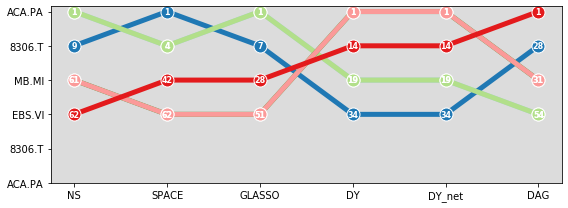

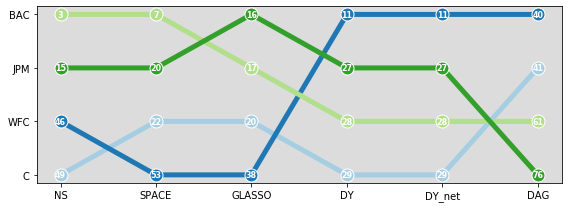

Date: 2020-12-23
Centrality type: eigenvector


NS          SPACE         GLASSO        DY    DY_net        DAG
0     WBC.AX           FITB         BNP.PA      FITB      FITB    BBVA.MC
1     ANZ.AX             RF            JPM    SAB.MC    SAB.MC     EBS.VI
2     NAB.AX            JPM         ACA.PA       COF       COF     LLOY.L
3     CBA.AX            BAC         SAN.MC        RF        RF    UBSG.SW
4         RF            USB            BAC       AXP       AXP     8355.T
..       ...            ...            ...       ...       ...        ...
71    D05.SI  BANKBARODA.NS      600036.SS   INGA.AS   INGA.AS  DANSKE.CO
72    U11.SI      600000.SS  BANKBARODA.NS    DNB.OL    DNB.OL     DNB.OL
73   SBER.ME      600016.SS      600016.SS   SBER.ME   SBER.ME    SBER.ME
74  ISCTR.IS      600036.SS      600000.SS  ISCTR.IS  ISCTR.IS   ISCTR.IS
75    SBK.JO      600015.SS      600015.SS    SBK.JO    SBK.JO     SBK.JO

[76 rows x 6 columns]

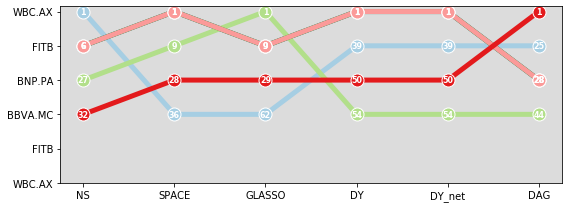

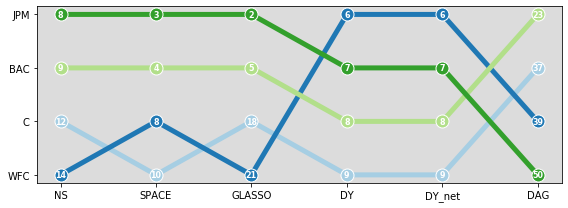

Date: 2020-12-23
Centrality type: closeness


NS          SPACE         GLASSO        DY    DY_net        DAG
0     EBS.VI          CM.TO       ITUB4.SA        RF        RF     DBK.DE
1    INGA.AS         BNS.TO        INGA.AS       AXP       AXP     8377.T
2     LLOY.L            AXP         DBK.DE    SAB.MC    SAB.MC     8355.T
3     KBC.BR         EBS.VI         8316.T       COF       COF    UBSG.SW
4     SAB.MC        SBIN.NS          CM.TO      FITB      FITB     LLOY.L
..       ...            ...            ...       ...       ...        ...
71  ITUB4.SA         NAB.AX      600000.SS   INGA.AS   INGA.AS  DANSKE.CO
72  BBDC4.SA      600016.SS         8418.T    DNB.OL    DNB.OL     DNB.OL
73   SBER.ME      600015.SS         8355.T   SBER.ME   SBER.ME    SBER.ME
74  ISCTR.IS  BANKBARODA.NS      600015.SS  ISCTR.IS  ISCTR.IS   ISCTR.IS
75    SBK.JO       ITUB4.SA  BANKBARODA.NS    SBK.JO    SBK.JO     SBK.JO

[76 rows x 6 columns]

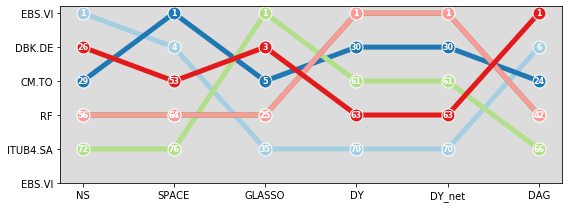

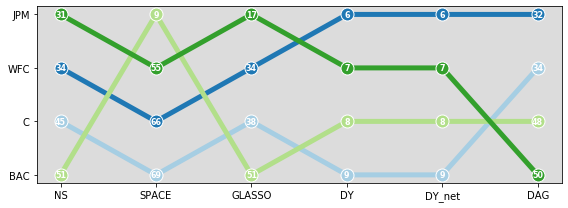

Date: 2020-12-23
Centrality type: betweenness


NS          SPACE         GLASSO        DY    DY_net        DAG
0      EBS.VI        CSGN.SW       ITUB4.SA       JPM       JPM     BNP.PA
1    SHB-A.ST        INGA.AS         DBK.DE       BAC       BAC     8331.T
2      KBC.BR         BNS.TO          CM.TO         C         C     SAN.MC
3       TD.TO          CM.TO        INGA.AS       WFC       WFC     8308.T
4      ISP.MI      024110.KS       BBDC4.SA        GS        GS  600000.SS
..        ...            ...            ...       ...       ...        ...
71     U11.SI         BNP.PA      600015.SS   INGA.AS   INGA.AS    INGA.AS
72  DANSKE.CO      055550.KS        UBSG.SW    DNB.OL    DNB.OL     DNB.OL
73    SBER.ME       ITUB4.SA  BANKBARODA.NS   SBER.ME   SBER.ME    SBER.ME
74   ISCTR.IS        BIRG.IR        SBER.ME  ISCTR.IS  ISCTR.IS   ISCTR.IS
75     SBK.JO  BANKBARODA.NS       ISCTR.IS    SBK.JO    SBK.JO     SBK.JO

[76 rows x 6 columns]

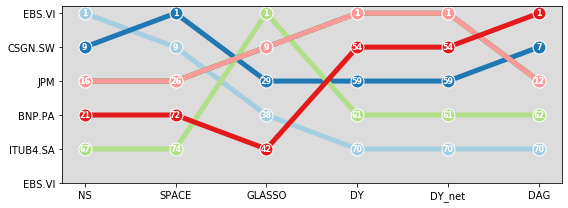

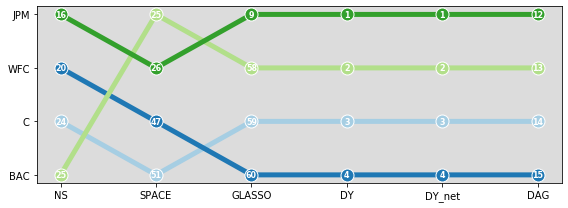

Date: 2020-12-23
Centrality type: degree


NS          SPACE         GLASSO         DY     DY_net        DAG
0     EBS.VI         EBS.VI         BNP.PA       FITB       FITB        JPM
1        JPM            JPM         EBS.VI     SAB.MC     SAB.MC     BNP.PA
2        USB         BNP.PA        INGA.AS         RF         RF     8306.T
3     8308.T        CSGN.SW        CSGN.SW        COF        COF     8331.T
4     8331.T        INGA.AS         KBC.BR        AXP        AXP      TD.TO
..       ...            ...            ...        ...        ...        ...
71    D05.SI      600016.SS       ISCTR.IS  DANSKE.CO  DANSKE.CO  DANSKE.CO
72    U11.SI      600015.SS      600000.SS    INGA.AS    INGA.AS     DNB.OL
73   SBER.ME      055550.KS      600016.SS     DNB.OL     DNB.OL    SBER.ME
74  ISCTR.IS       ITUB4.SA      600015.SS    SBER.ME    SBER.ME   ISCTR.IS
75    SBK.JO  BANKBARODA.NS  BANKBARODA.NS   ISCTR.IS   ISCTR.IS     SBK.JO

[76 rows x 6 columns]

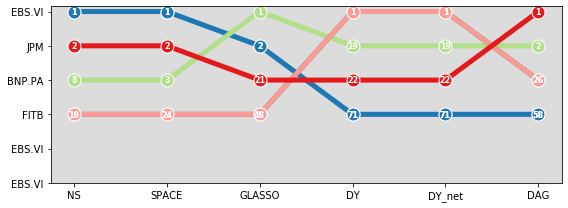

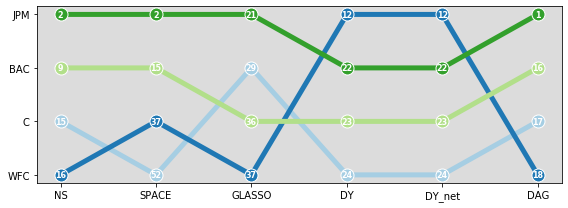

Date: 2020-12-23
Centrality type: katz-bonacich


NS      SPACE         GLASSO        DY    DY_net        DAG
0      BNP.PA     BNP.PA         BNP.PA      FITB      FITB     ACA.PA
1      8316.T        JPM        CSGN.SW    SAB.MC    SAB.MC     SAN.MC
2   600000.SS     ANZ.AX            JPM       COF       COF    UBSG.SW
3         JPM  600000.SS         ACA.PA        RF        RF    INGA.AS
4        FITB     SAN.MC         ISP.MI       AXP       AXP    BBVA.MC
..        ...        ...            ...       ...       ...        ...
71     8604.T      MB.MI         MQG.AX   INGA.AS   INGA.AS  DANSKE.CO
72     MQG.AX     MQG.AX        SBER.ME    DNB.OL    DNB.OL     DNB.OL
73    SBER.ME     SBK.JO         SBK.JO   SBER.ME   SBER.ME    SBER.ME
74   ISCTR.IS    SBER.ME  BANKBARODA.NS  ISCTR.IS  ISCTR.IS   ISCTR.IS
75     SBK.JO   ISCTR.IS       ISCTR.IS    SBK.JO    SBK.JO     SBK.JO

[76 rows x 6 columns]

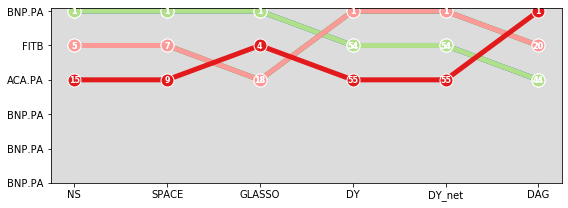

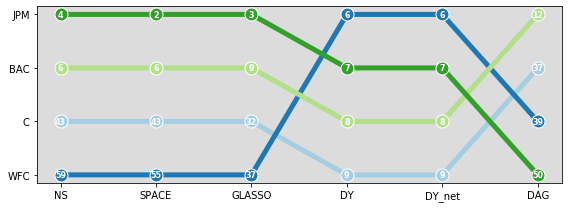

In [17]:
# Parameters
varnames = var_names
cross_holdings = False
asset_sizes = False

ts_type = "return"
base_path = "./Data/Large_network/Estimated_networks/largenet_"
data_type = "largenet"
chosen_varnames = ["C","WFC","BAC","JPM"]



# Iterables
methods = ['NS','SPACE','GLASSO','DY','DY_net','DAG'] #['NS','SPACE','GLASSO','DAG'] #['NS','SPACE','GLASSO','DY','DAG']
centrality_types = ["eigenvector" ,"closeness" ,"betweenness", "degree" ,"katz-bonacich"]
#dates = ["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"] #["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"]
dates = ["2019-12-31","2020-03-31","2020-06-30","2020-09-30","2020-12-31"] #["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"]


for date in dates:
    for centrality_type in centrality_types:

        # Create dictionary to store the outputs
        networks = {}

        for method in methods:

            networks[method] = network_preprocessing_general(date,method,ts_type,base_path)



        print("Date: {}".format(date))
        print("Centrality type: {}".format(centrality_type))


        # Create centrality rankings
        if cross_holdings:
            CH_network = CH_network
        else:
            CH_network = None

        if asset_sizes:
            varnames_sorted_by_asset = varnames_sorted_by_asset
        else:
            varnames_sorted_by_asset = None

        # Create centrality rankings
        ranking_df = centrality_ranking_df(centrality_type,networks,varnames,varnames_sorted_by_asset,CH_network)

        # Inspect the dataframe
        display(ranking_df)

        # Parameters
        current_winners = list(ranking_df.loc[0])

        # Run the visualisation function
        rank_viz_general(current_winners,ranking_df,centrality_type,date,ts_type,data_type)


        # Run the visualisation function
        rank_viz_general(chosen_varnames,ranking_df,centrality_type,date,ts_type,data_type)

# Robustness/persistence checks

In [14]:
# Parameters
dates = ["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"] #["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"]
dates = ["2019-12-31","2020-03-31","2020-06-30","2020-09-30","2020-12-31"]
ts_type = "return"
base_path = "./Data/Large_network/Estimated_networks/largenet_"
data_type = "largenet"

# Iterables
methods = ['NS','SPACE','GLASSO','DY','DY_net','DAG'] #['NS','SPACE','GLASSO','DAG'] #['NS','SPACE','GLASSO','DY','DAG']

# Placeholder

In [15]:
# Check robustness results
robustness_results = {}

for method in methods:
    
    res = []
    
    for i in range(1,len(dates)):
        
        current_dates = dates[i-1:i+1]
        
        frob_norm = general_robustness_check(current_dates,method,ts_type,base_path)
        res.append(frob_norm)
        
    robustness_results[method] = res

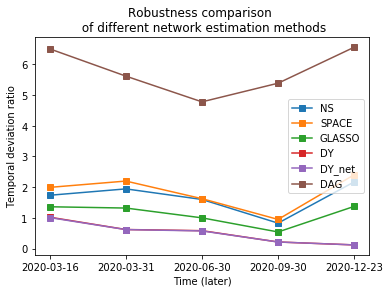

In [20]:
for key, val in robustness_results.items():
    
    plt.plot(val,marker="s",label=key)
    
plt.legend(loc = 'center right')
plt.title("Robustness comparison \n of different network estimation methods")
#plt.yscale('log')
plt.xlabel("Time (later)")
plt.ylabel("Temporal deviation ratio")
plt.xticks(np.arange(len(dates)-1),dates[1:])
plt.savefig('./Figures/Large_network/persistence_robustness.pdf',dpi=120)
plt.show()

# Visualise network

## Single examples

Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

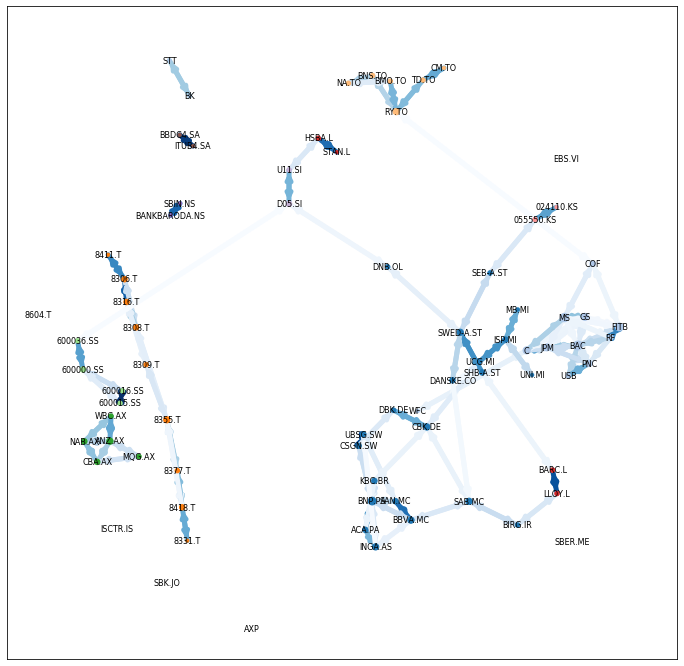

Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

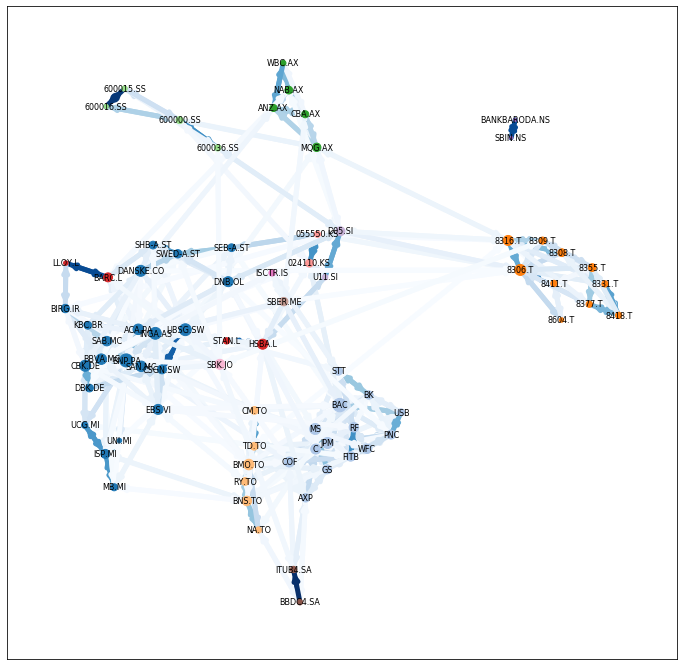

Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

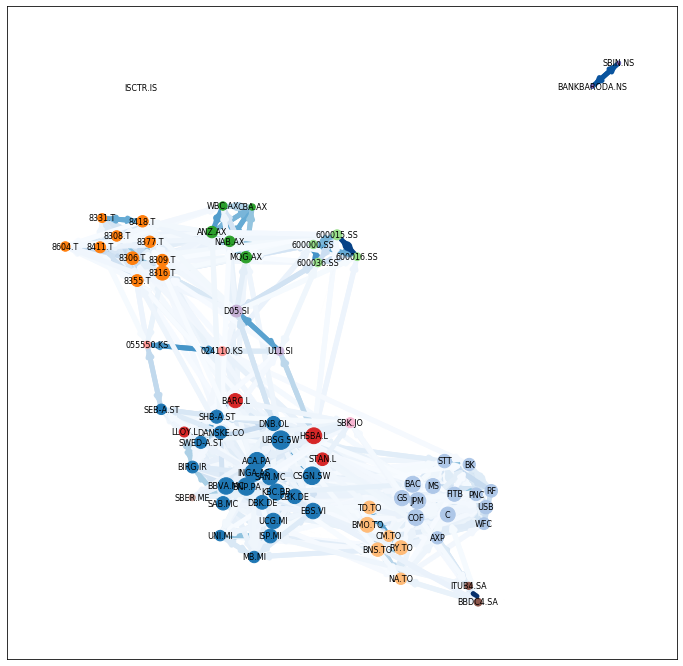

Method: DY


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

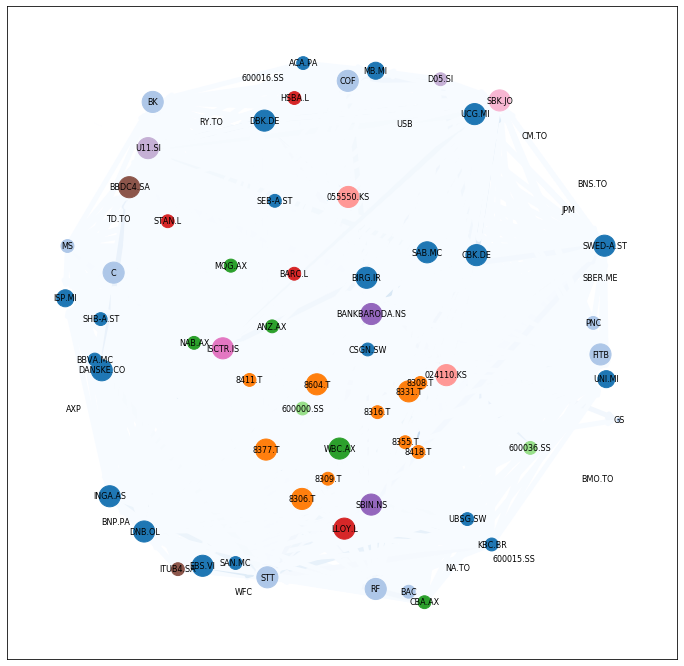

Method: DY_net


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

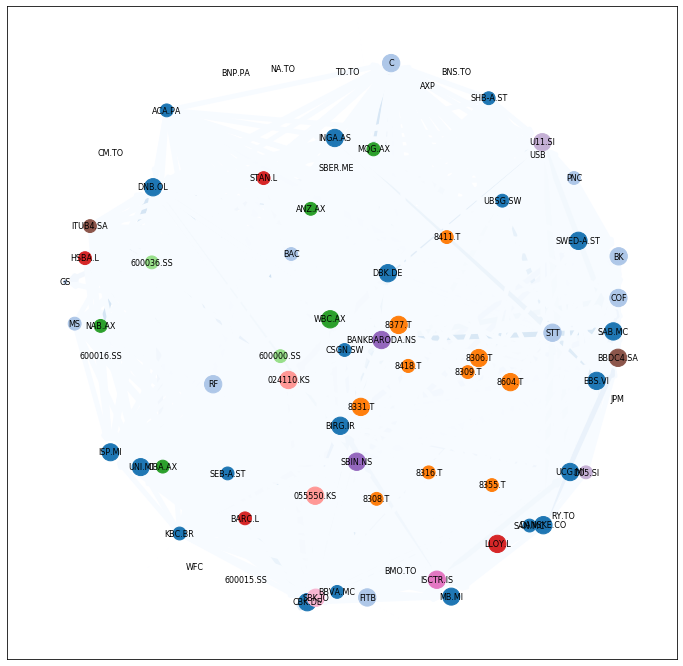

Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

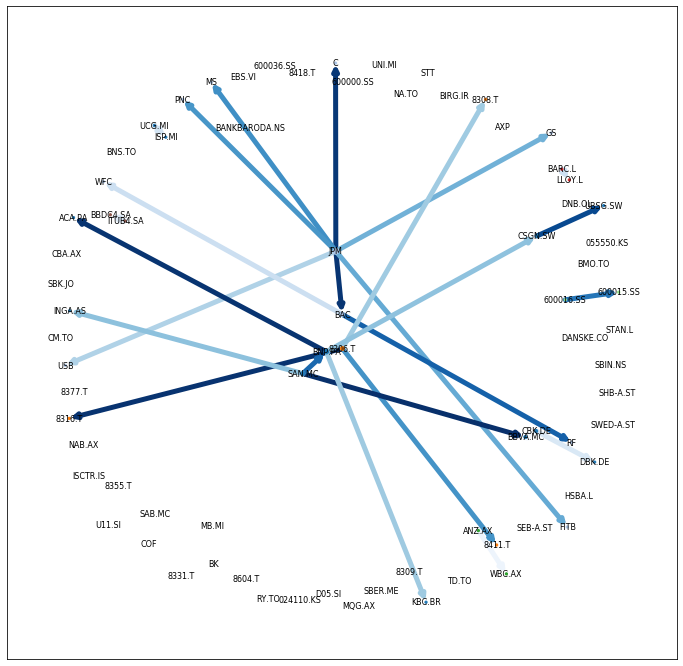

In [21]:
# Parameters
date = "2019-12-31" #"2020-06-30"
ts_type = "return"

# Iterables
methods = ['NS','SPACE','GLASSO','DY','DY_net','DAG']

for method in methods:
    
    network_viz_general(date,method,ts_type,var_names,country_colors, base_path, data_type)

## Combinations

Date: 2019-12-31
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

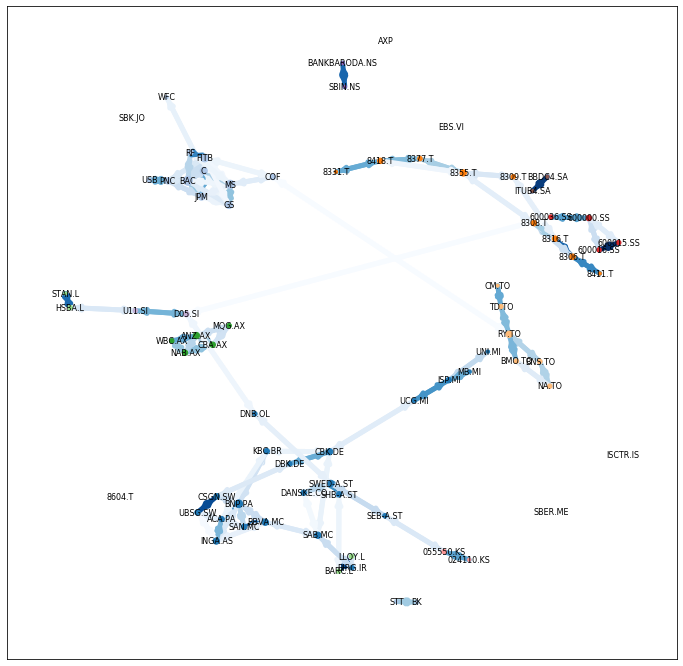

Date: 2019-12-31
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

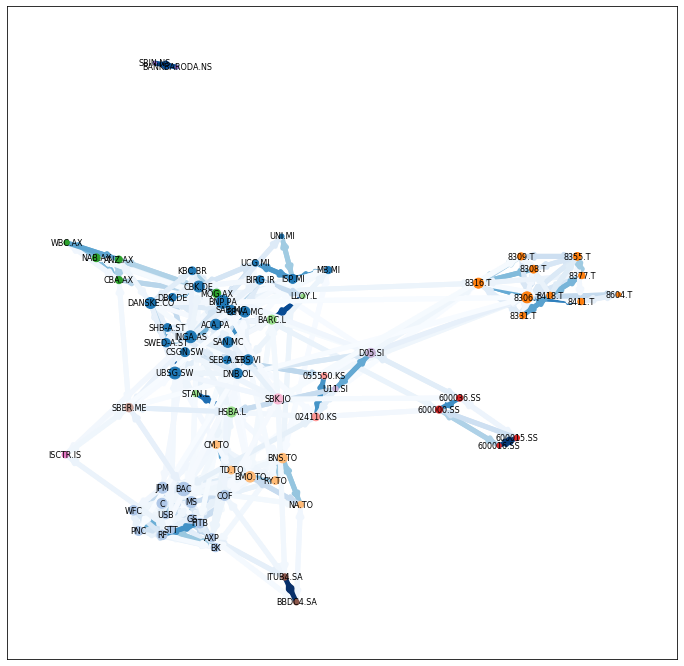

Date: 2019-12-31
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

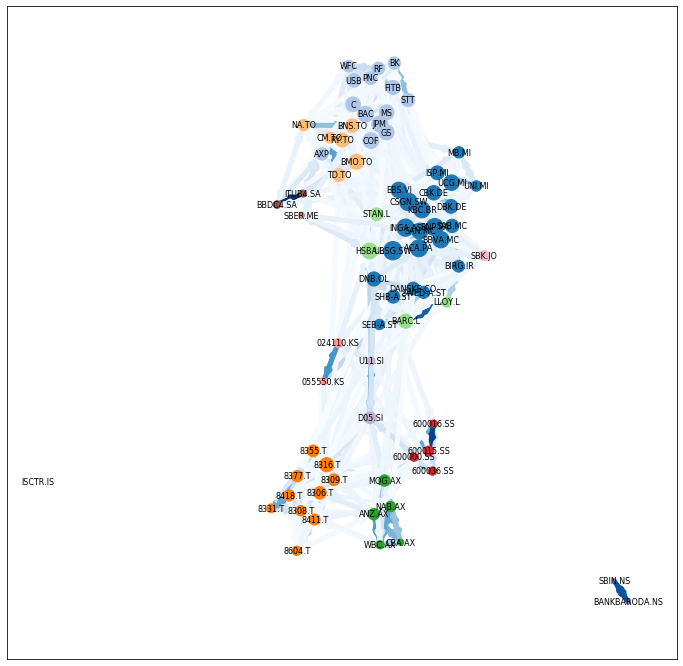

Date: 2019-12-31
Method: DY


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

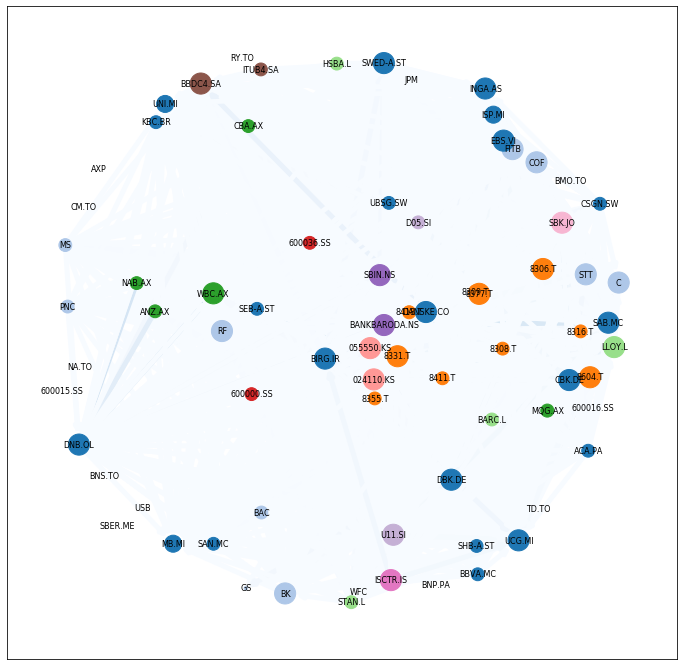

Date: 2019-12-31
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

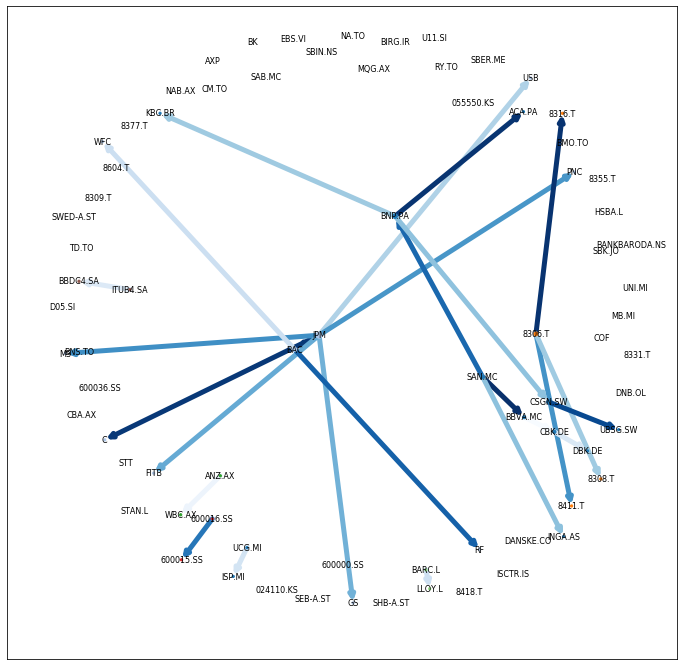

Date: 2020-03-16
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

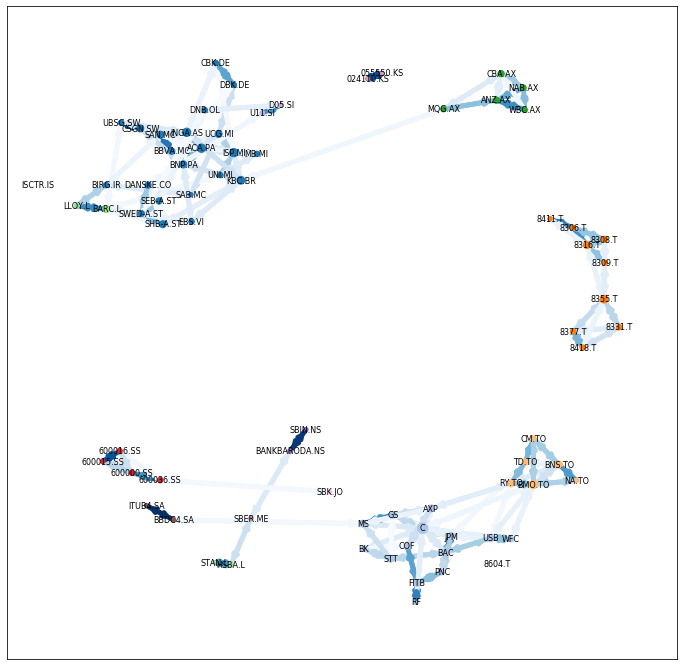

Date: 2020-03-16
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

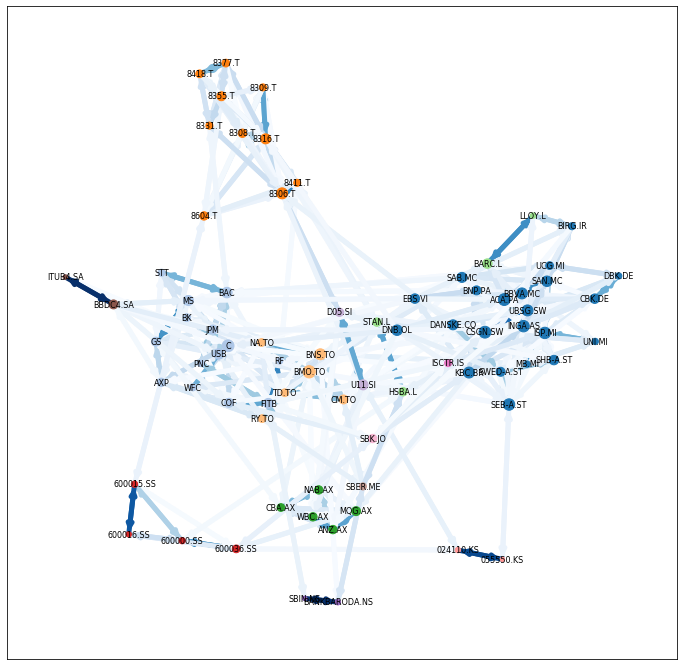

Date: 2020-03-16
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

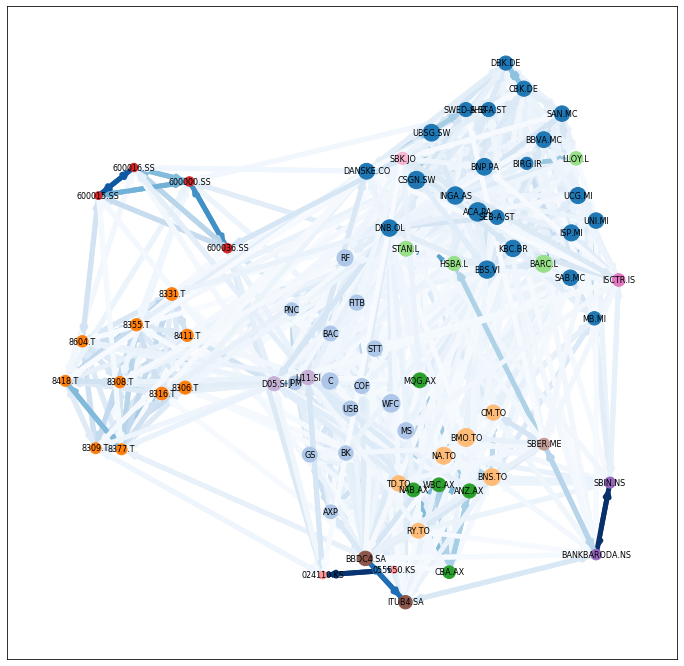

Date: 2020-03-16
Method: DY


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

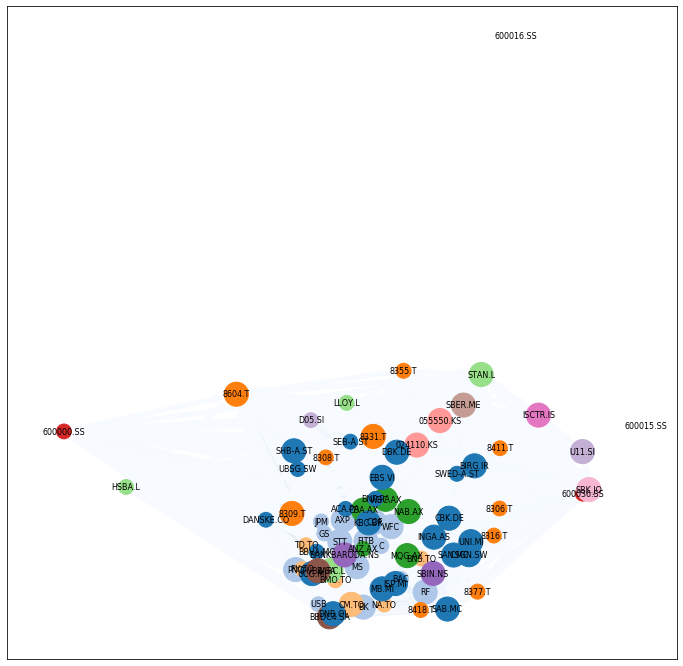

Date: 2020-03-16
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

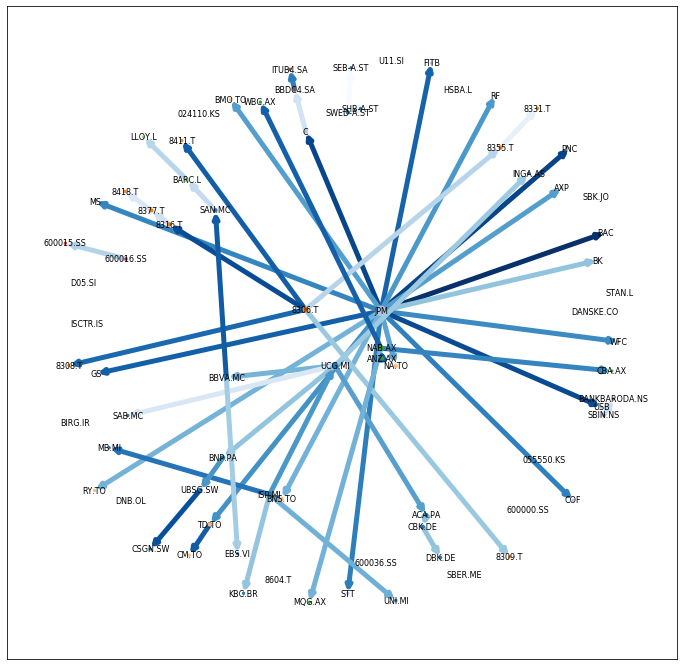

Date: 2020-03-31
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

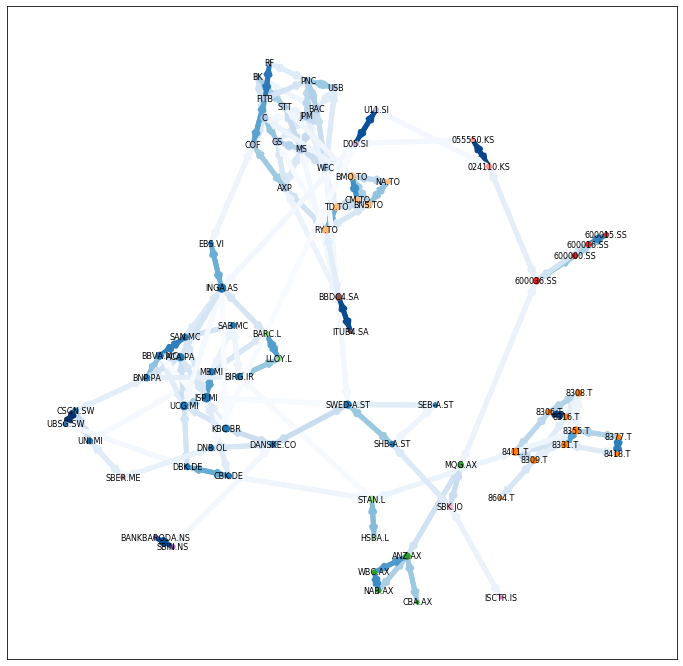

Date: 2020-03-31
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

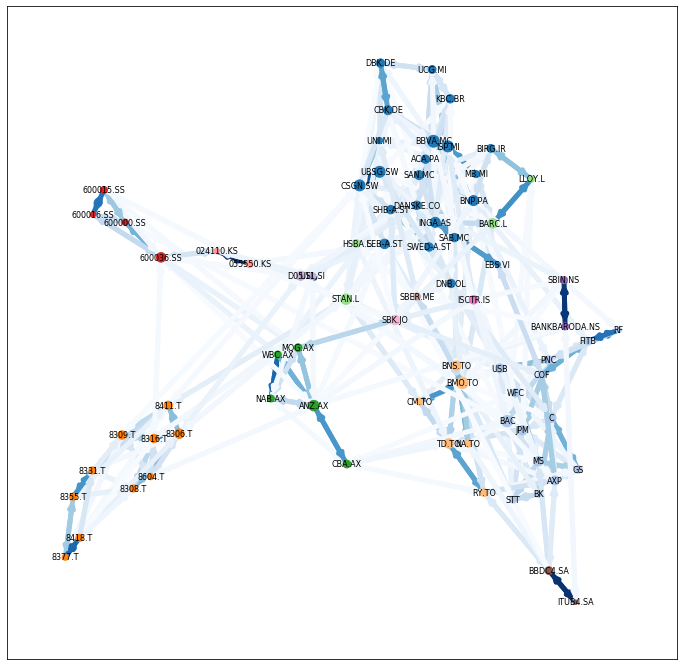

Date: 2020-03-31
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

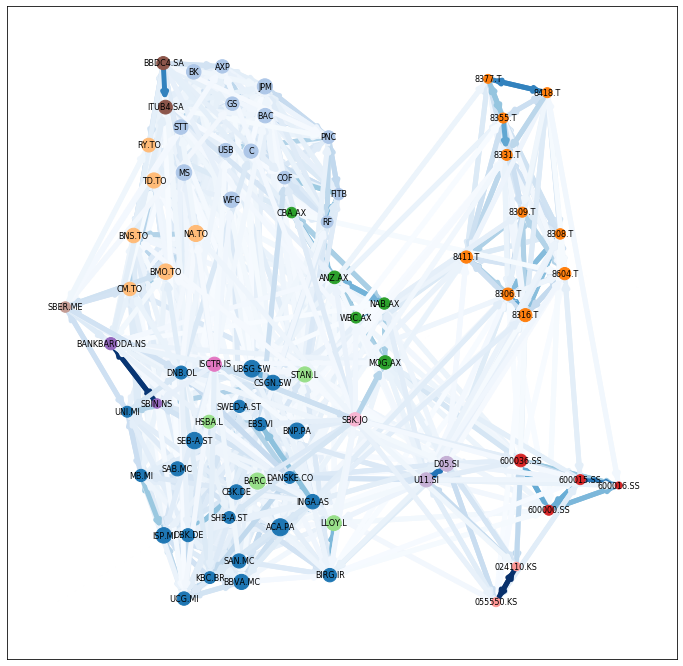

Date: 2020-03-31
Method: DY


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

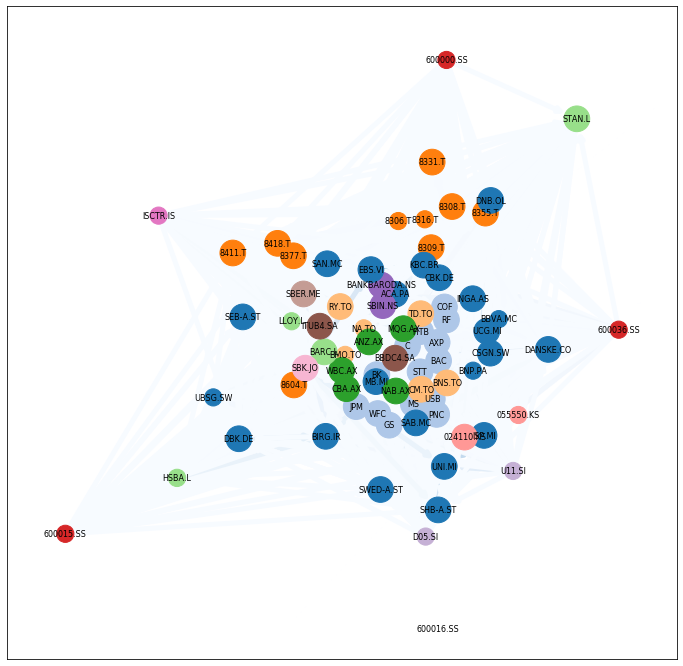

Date: 2020-03-31
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

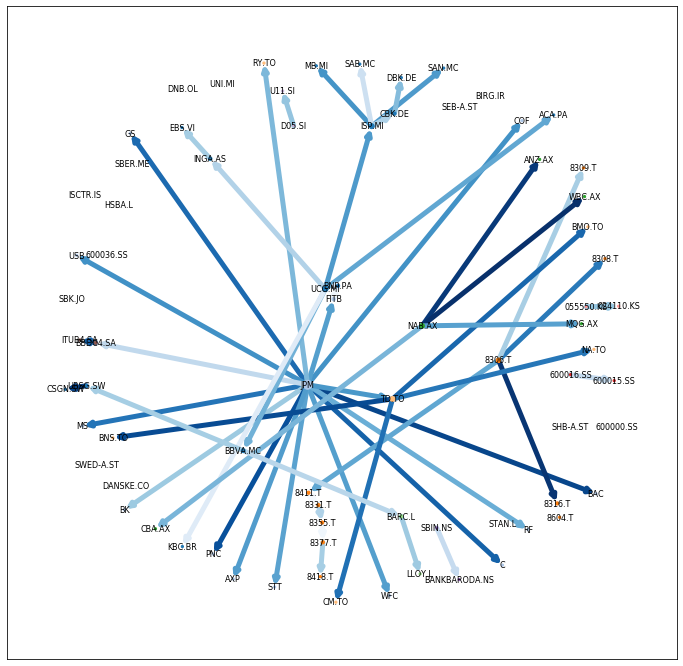

Date: 2020-06-30
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

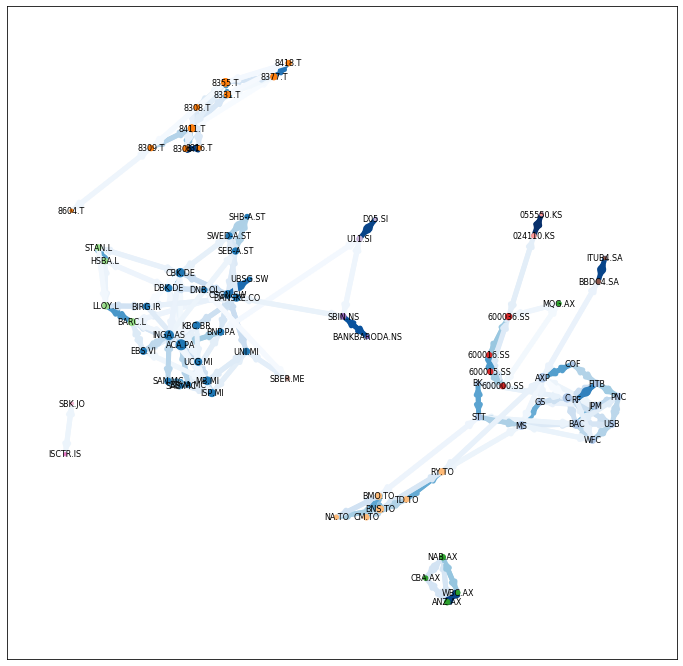

Date: 2020-06-30
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

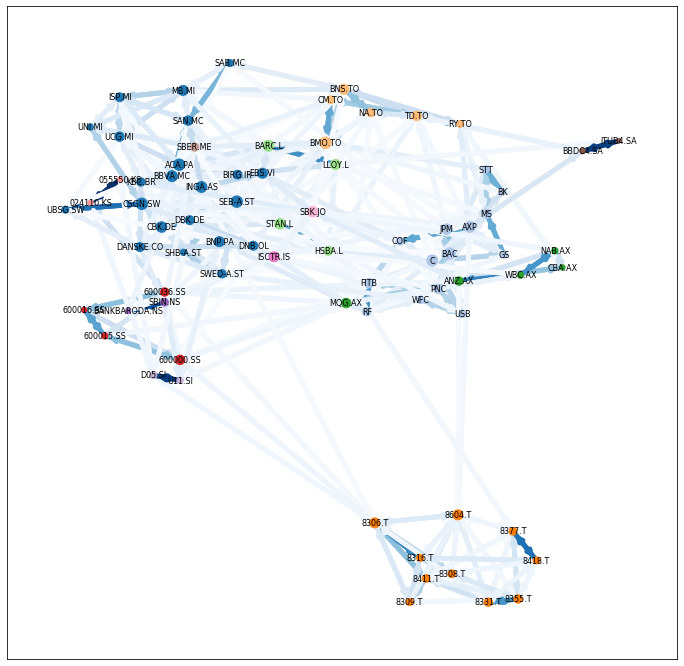

Date: 2020-06-30
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

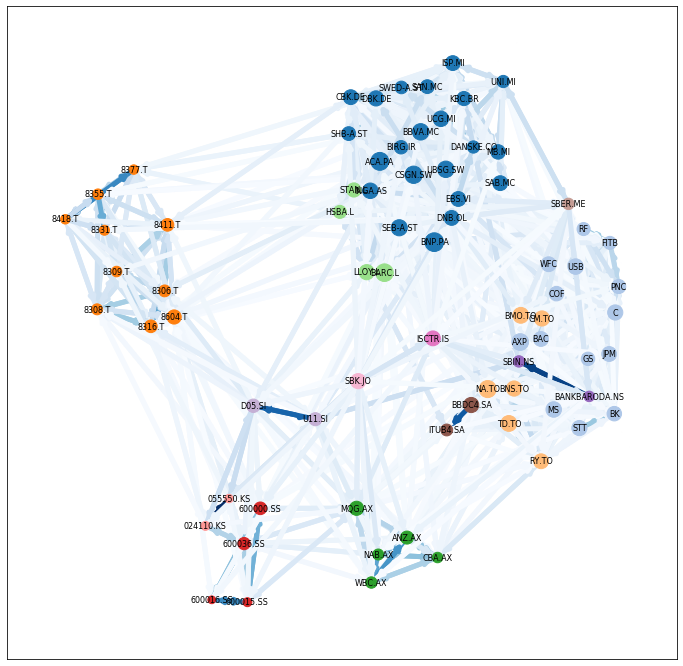

Date: 2020-06-30
Method: DY


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

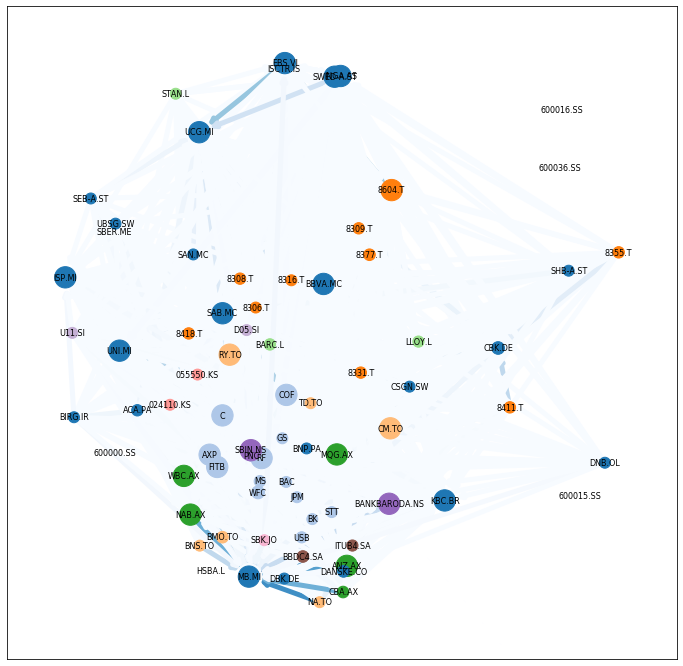

Date: 2020-06-30
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

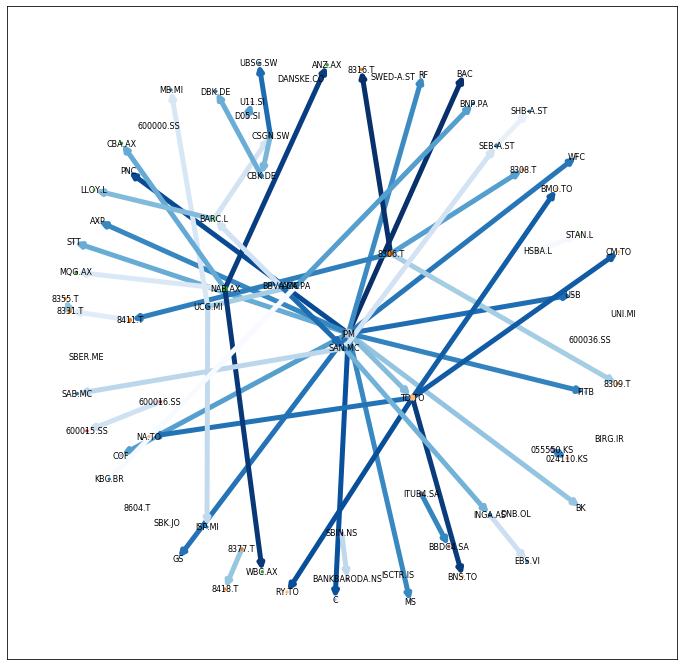

Date: 2020-09-30
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

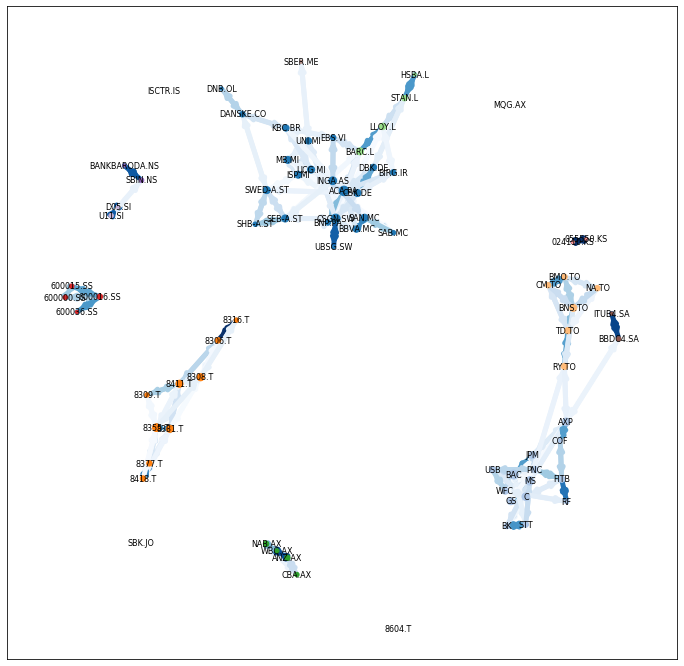

Date: 2020-09-30
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

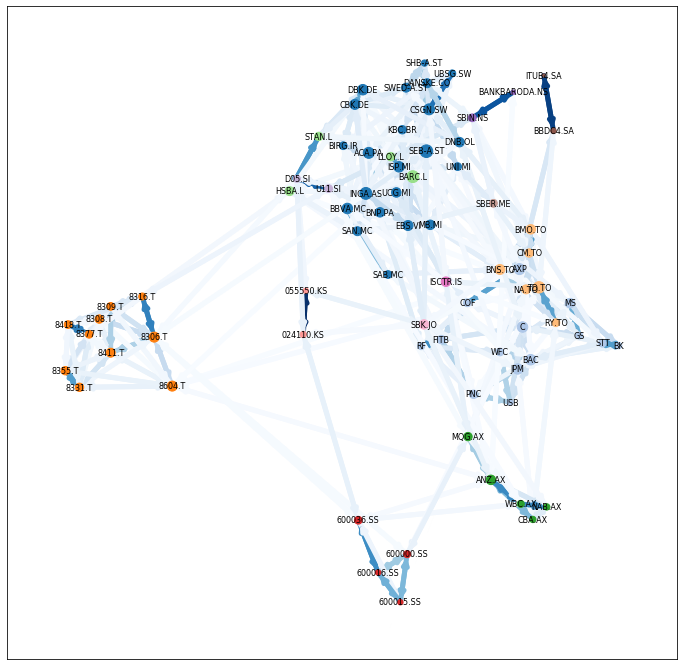

Date: 2020-09-30
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

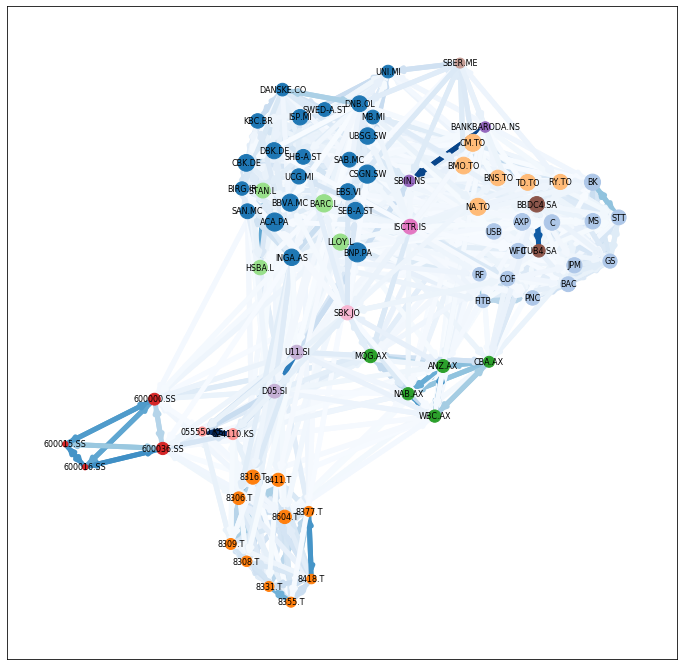

Date: 2020-09-30
Method: DY


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

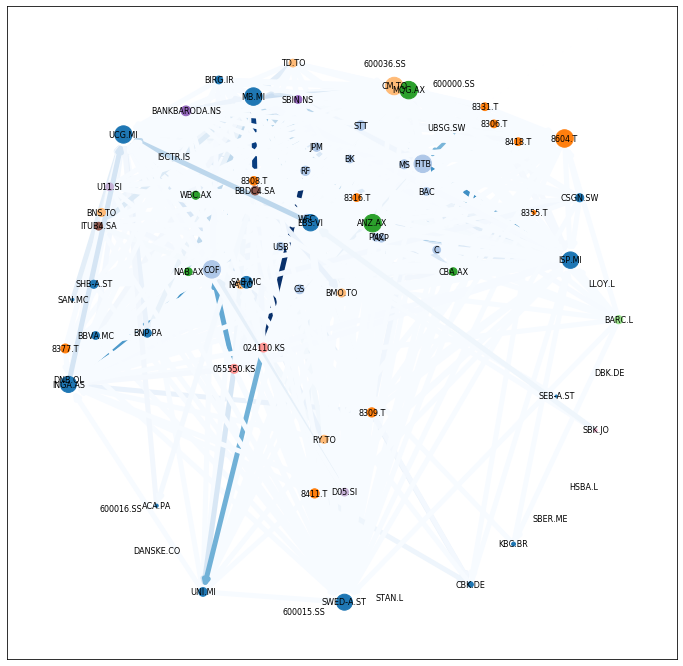

Date: 2020-09-30
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

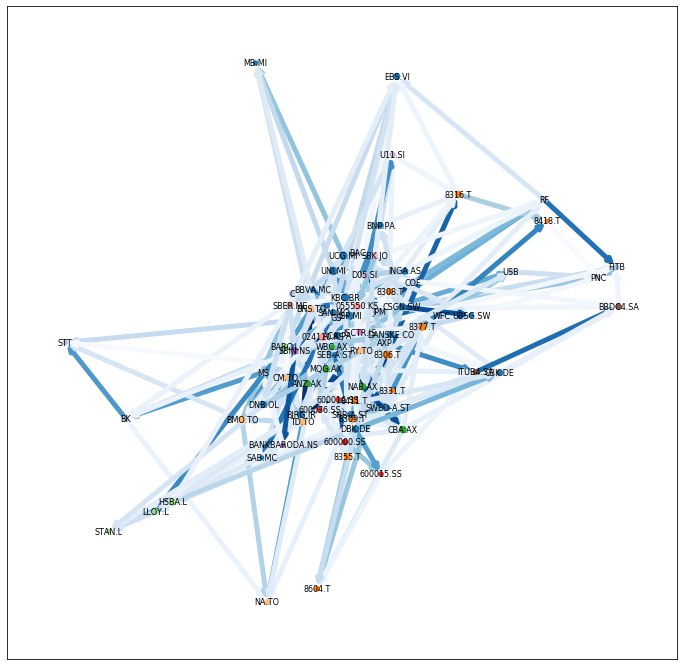

Date: 2020-12-23
Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

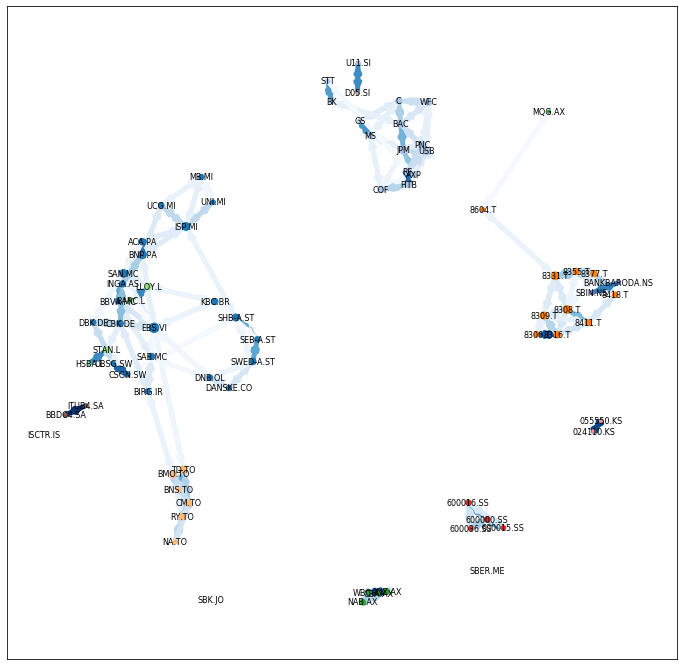

Date: 2020-12-23
Method: SPACE


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

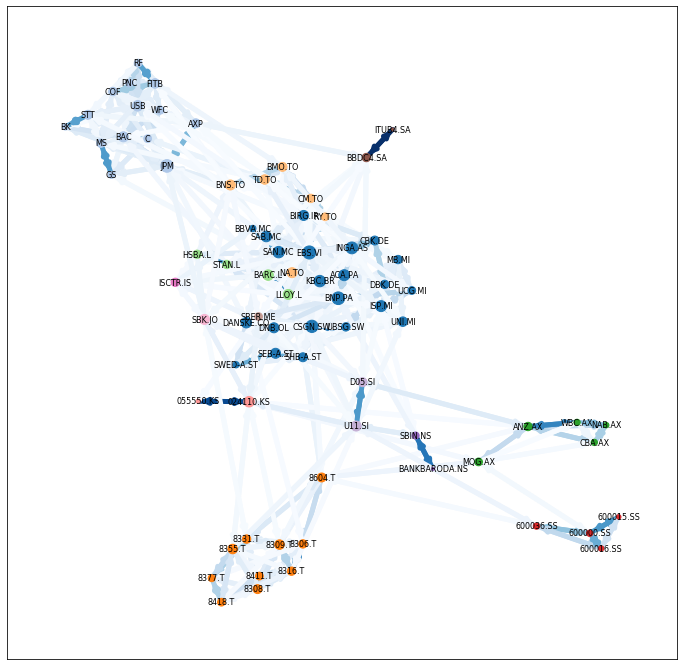

Date: 2020-12-23
Method: GLASSO


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

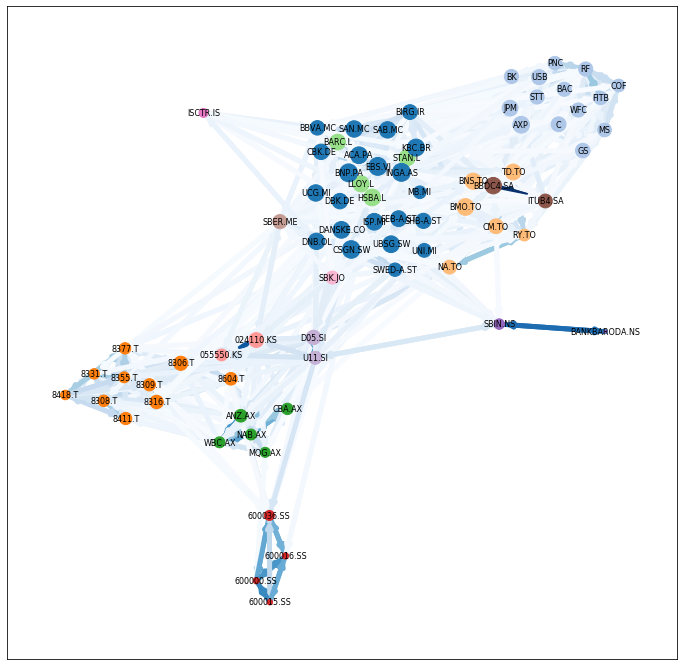

Date: 2020-12-23
Method: DY


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

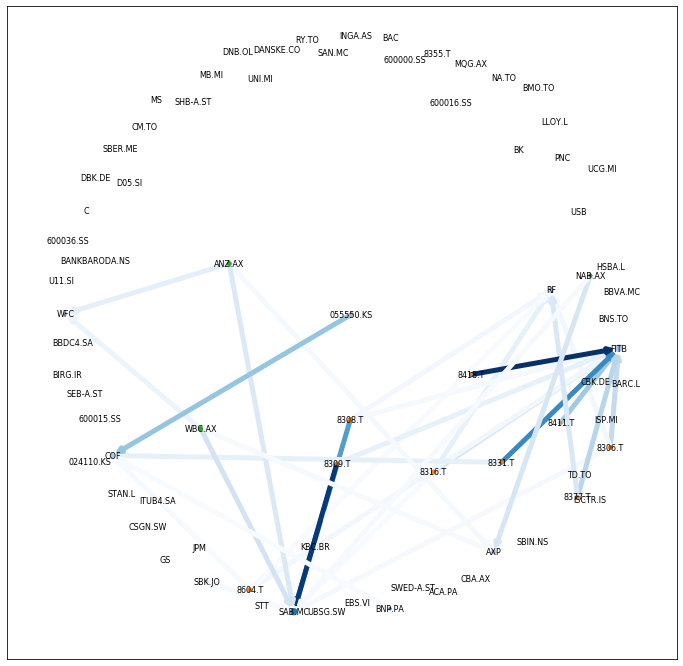

Date: 2020-12-23
Method: DAG


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

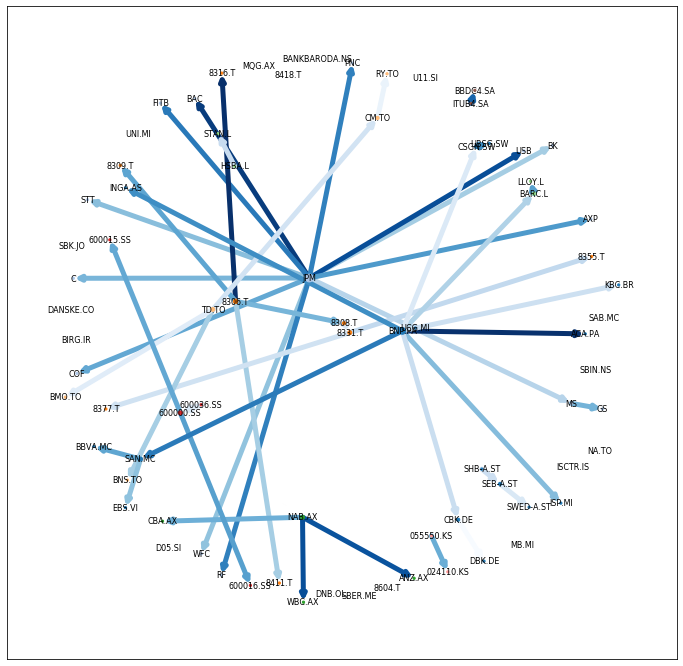

In [21]:
# Parameters
ts_type = "return"

# Iterables
#dates = ["2019-12-31","2020-03-16","2020-03-31","2020-06-30","2020-09-30","2020-12-23"]
dates = ["2019-12-31","2020-03-31","2020-06-30","2020-09-30","2020-12-31"]
methods = ['NS','SPACE','GLASSO','DY','DAG'] #['NS','SPACE','GLASSO','DY','DY_net','DAG']

for date in dates:

    for method in methods:
        
        print("Date: {}".format(date))

        network_viz_general(date,method,ts_type,var_names,country_colors, base_path, data_type)

# Support

In [45]:
label_dict = {}

for i in range(0,len(var_names)):
    label_dict[i] = var_names[i]
    
# Relabel network
G = nx.relabel_nodes(G, label_dict)

In [46]:
# Get edge weights
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

In [47]:
# Customize ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=0.2, #1.0,

                        # Log
                        verbose=True)

In [48]:
# Parameters
plt.rcParams['figure.figsize'] = (12,12)

# Get degrees
degree_demirer = dict(G.degree)

#node_pos = forceatlas2.forceatlas2_networkx_layout(G, niter=1000)
node_pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:00<00:00, 2476.97it/s]

BarnesHut Approximation  took  0.21  seconds
Repulsion forces  took  0.39  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

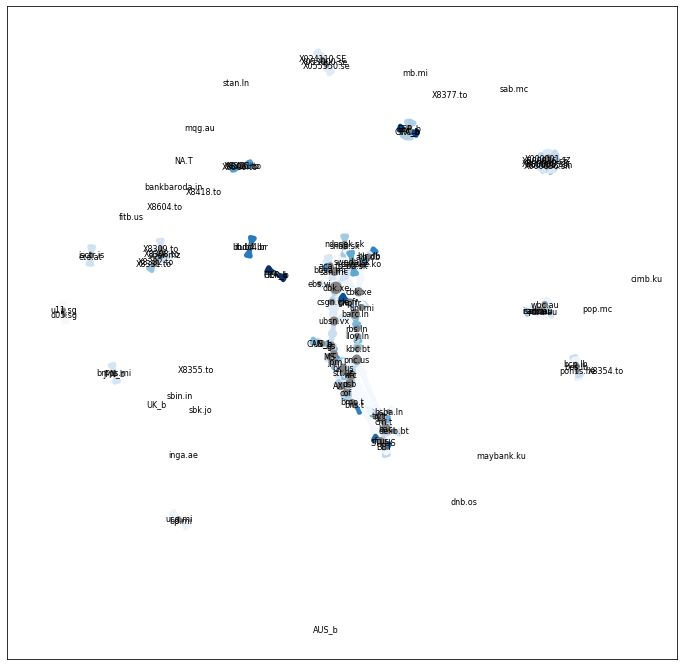

In [49]:
# Draw network
nx.draw_networkx(G,node_pos,
                     #nodelist=degree_mcc_network.keys(),
                     node_size=[v * 8 for v in degree_demirer.values()],
                     #node_color=colors,
                     font_size=8, node_color='grey',
                 edgelist=edges,
                 edge_color=weights,
                 width=5.0, edge_cmap=plt.cm.Blues,
                     with_labels=True)

plt.savefig('./Figures/Demirer_network_{}_{}_{}.pdf'.format(ts_type,method,date),dpi = 120)

In [52]:
# equivalently
GI = igraph.Graph.TupleList(G.edges(), directed=False)
layout = forceatlas2.forceatlas2_igraph_layout(GI, pos=None, iterations=2000)
igraph.plot(GI).show()

100%|██████████| 2000/2000 [00:00<00:00, 3438.58it/s]


BarnesHut Approximation  took  0.16  seconds
Repulsion forces  took  0.26  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


Method: NS


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

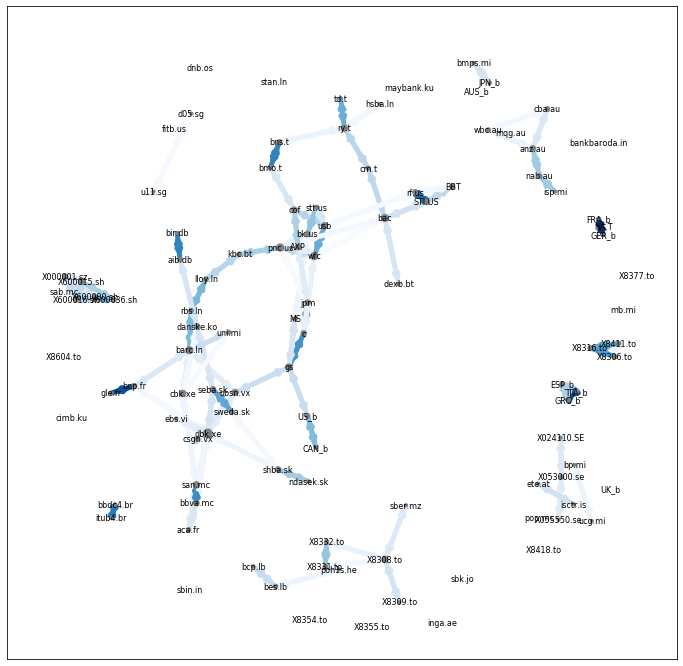

Method: DY_Lasso


/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable ins

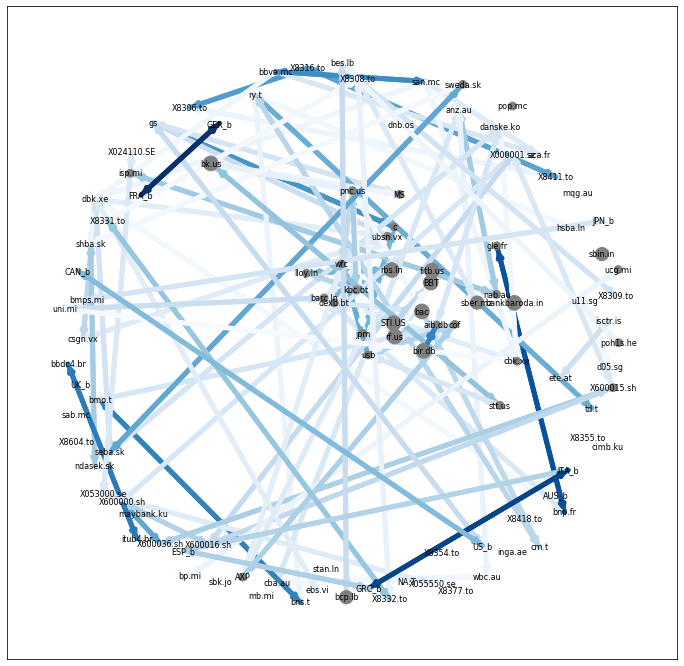

In [53]:
# Iterable (Methods to check)
methods = ["NS","DY_Lasso"]

# Other parameters
date = "2008-09-15"
ts_type = "volatility"

for method in methods:
    
    print("Method: {}".format(method))
    
    # Import network
    G = network_preprocessing(date,method,ts_type)
    
    label_dict = {}

    for i in range(0,len(var_names)):
        label_dict[i] = var_names[i]

    # Relabel network
    G = nx.relabel_nodes(G, label_dict)
    
    
    # Parameters
    plt.rcParams['figure.figsize'] = (12,12)

    # Get degrees
    degree_demirer = dict(G.degree)

    # Draw network
    nx.draw_networkx(G,
                         #nodelist=degree_mcc_network.keys(),
                         node_size=[v * 5 for v in degree_demirer.values()],
                         #node_color=colors,
                         font_size=8, node_color='grey',
                     edgelist=edges,
                     edge_color=weights,
                     width=5.0, edge_cmap=plt.cm.Blues,
                         with_labels=True)

    plt.savefig('./Figures/Demirer_network_{}_{}_{}.pdf'.format(ts_type,method,date),dpi = 120)
    plt.show()

In [44]:
# # Really naive example
# nx.draw(G, pos=nx.spring_layout(G))